In [4]:
import numpy as np
import Bio.PDB
from Bio import SeqIO
from Bio import PDB
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from matplotlib import rcParams #for changing default font to arial. 
import matplotlib.colors as colors #for coloring points
from matplotlib.colors import TwoSlopeNorm #for color scale normalization
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import pandas as pd 
#import random
from scipy import stats
from scipy.optimize import curve_fit
import os
import sys
import pylab
from scipy.signal import find_peaks
import ipywidgets as widgets
import statsmodels.formula.api as sm
import matplotlib.animation as animation

#output the conda environment 
#conda env export > spectra_melt.yml

The goal of this workbook is to take data generated from a Jasco J-815 CD Spectrometer and analyze it for 

1. The far UV spectra in the light and dark.
2. The alpha helical content as measured by CD at 222nm at different temperatures to determine the thermal stability of the protein in the light and dark.
3. Determine the effect of this light dependent effect on thermal stability and compare it with the light dependent effect on transition state thermodynamics.

James McCormick and Kimberly Reynolds 2024. 

This notebook is the companion to Thermal_kinetics_and_stability_analysis. 

In [20]:
#change global font settings in plots: 
rcParams['font.family'] = "Arial"
rcParams.update({"axes.grid" : True, "grid.color": "#999999"})
rcParams['lines.markersize'] = 4
rcParams.update({'font.size': 10})
rcParams["figure.figsize"] = (2,1.5)

###Units of CD Measurement

CD is reported in units of absorbance or ellipticity.
Each of these can be normalized for molar
concentration of the sample. The most direct
data from the Olis CD instrument is absorbance
(Abs(L)- Abs(R)). This value is often reported in
milliabsorbance units (mA), which are a thousandth
of an absorbance unit.

CD data are commonly reported as ellipticity (θ),
which is related to absorbance by a factor of 32.98
(θ = 32.98 ΔAbs). Ellipticity is usually reported in
millidegrees (mdeg or mο), which are a thousandth
of a degree.

Molar ellipticity ([θ]) is CD corrected for
concentration. The units of molar ellipticity are
historical (deg×cm2/dmol). Conversion from molar
extinction (absorbance corrected for concentration)
to molar ellipticity uses a factor of 3298 ([θ] =
3298Δε). To calculate molar ellipticity, the sample
concentration (g/L), cell pathlength (cm), and the
molecular weight (g/mol) must be known.

If the sample is a protein, the mean residual
weight (average molecular weight of the amino
acids it contains) is used in place of the molecular
weight, essentially treating the protein as a
solution of amino acids

mean residue molar ellipticity

A note on HT signal


HT (photo-‐multiplier) voltage o The CD instrument has a HT voltage reading that is shown on the screen and recorded with the data. This HT voltage is a measure of how much voltage the detector is using and is dependent on the amount of light striking the detector (more light – lower HT voltage)

In [6]:
def cd_convert(CD_values, sample_concentration, cell_pathlength, molecular_weight): 
    #UNITS:
    #CD values should be in millidegrees. m°
    #Concentration should be in g/L or mg/ml. C
    #path length is in cm. L (0.1cm or 1mm is used)
    #molecular weight (average) should be in g/mol. M
    #DL121 is 34947.47 daltons or g/mol. 
    #units of Molar Ellipticity (the result) should be deg*cm^2/dmol (historical reasons). Θ
    #dmol = 0.1mol
    #formula is Θ=m°*M/(10*L*C)
    
    #unit formula:
    #deg*cm^2/dmol =  millidegrees * g/mol
    #                -----------------------
    #                   10 * cm * g/L    
    #
    #              =   degrees * g/mol
    #                -----------------------
    #                  1,000 * 10 * cm * g/L    
    #
    #              =   degrees * L
    #                -----------------------
    #                  10,000 * cm * mol   
    #
    #              =   degrees * 1,000 * cm^3
    #                -----------------------
    #                  10,000 * cm * 10 * dmol   
    #
    #              =   degrees * cm^2
    #                -----------------------
    #                  100 * dmol    
    # hmm... I dont understand why there is an extra 100 popping out. 
    #can also divide the molecular weight by peptide count. which for purified DL121 in 2022-2024 is 307 which equals 113.8354072
    molar_ellipticity = np.divide(np.multiply(CD_values,molecular_weight),\
                                   (np.multiply(np.multiply(cell_pathlength,sample_concentration),10)))
    return molar_ellipticity

In [7]:
#should we save our output files to pdf?
#change this to 'yes' to save outputs to pdf. 
to_plot = 'no'

A circular dichroism experiment on DL121 was performed where three spectral scans of the protein in the dark and then light were performed. 

The temperature was then increased and scans repeated (see methods for more information).

The lit samples had an 455nm LED that flashed for 250ms every 10s. The flash shows up in the CD measurements and needs to be removed. 
The idea is that with three scans every point in the spectra can be read where there is no flash. 
The code below will remove regions where there is a LED flash (convert the data to NAN) and then average the scans. 
Traditionally the CD machine will do multiple scans and then average on-board. 

In [8]:
#load the list of all the file names
spectrum_path = './input_data/spectrum/'
master_list = pd.read_csv(spectrum_path + 'list.csv',header=(0))
master_list
#temp 115, 116, and 117 are not done at that temperature. They are scans at 15C after the heating to check for reversibility

,Temp,Light,Read 1,Read 2,Read 3
0,5.0,Dark,DL121 5C Dark 2-1.csv,DL121 5C Dark 2-2.csv,DL121 5C Dark 2-3.csv
1,5.0,Lit,DL121 5C Lit-1.csv,DL121 5C Lit-2.csv,DL121 5C Lit-3.csv
2,10.0,Dark,DL121 10C Dark-1.csv,DL121 10C Dark-2.csv,DL121 10C Dark-3.csv
3,10.0,Lit,DL121 10C Lit-1.csv,DL121 10C Lit-2.csv,DL121 10C Lit-3.csv
4,15.0,Dark,DL121 15C Dark-1.csv,DL121 15C Dark-2.csv,DL121 15C Dark-3.csv
5,15.0,Lit,DL121 15C Lit-1.csv,DL121 15C Lit-2.csv,DL121 15C Lit-3.csv
6,20.0,Dark,DL121 20C Dark-1.csv,DL121 20C Dark-2.csv,DL121 20C Dark-3.csv
7,20.0,Lit,DL121 20C Lit-1.csv,DL121 20C Lit-2.csv,DL121 20C Lit-3.csv
8,25.0,Dark,DL121 25C Dark-1.csv,DL121 25C Dark-2.csv,DL121 25C Dark-3.csv
9,25.0,Lit,DL121 25C Lit-1.csv,DL121 25C Lit-2.csv,DL121 25C Lit-3.csv


Description for the change detector. 

It uses this "flipper function" because a ligth blip, which lowers the HV signal, does not change only one point but is like pushing down on a sheet. 
It causes a dip in the scan where neighboring points are also pushed down as the sample/light stops glowing. 
Therefore when a change is detected (the strong blip) the code drops the next 10 points and looks for the outer edge of the changing points. It removes more data than needed (possibly), but because the other two scans never have a blip overlap, the averaging fills in the gaps. 

In [9]:
#lets make it a function
def change_detector(x, y, ycd): 
    #x = spectra_1.wavelength.values
    #y = spectra_1.HT.values
    #ycd = spectra_1.CD

    jump_idxs = []
    ## compute the second derivative to identify jumps. # dy = diff(y, n=1)/dx
    deriv = np.diff(y, n=2)
    #deriv = np.gradient(y)

    ## find index locations of jumps
    jump_threshold = 0.5
    jump_idxs_temp = np.where(np.abs(deriv)>jump_threshold)[0]
    #jump_idxs_temp = np.where(deriv<jump_threshold)[0]
    j=0
    flipper = "start"
    for i in jump_idxs_temp:
        j=j+1
        if np.any(jump_idxs) == False:
            jump_idxs.append(i)
            flipper = "end"
        else:
            try: 
                i < np.add(jump_idxs_temp[j],10)
            except IndexError:
                jump_idxs.append(i)
                flipper = "end"
                continue
            if flipper == "start":
                #-1 to adjust for second derivative
                if i > np.add(jump_idxs[-1],30):
                    flipper = "end"
                    jump_idxs.append(i)
            else:
                #this is to find the outer edge, where there shouldnt be another blip for a while
                if i < np.add(jump_idxs_temp[j],-30) and i > np.add(jump_idxs[-1],10):
                    flipper = "start"
                    jump_idxs.append(i)
    flipper = "off"
    for i in ycd.index:
        if flipper == "off":
            if i in jump_idxs:
                ycd.values[i] = "NaN"
                flipper = "on"
        else:
            if flipper == "on":
                ycd.values[i] = "NaN"
                if i in jump_idxs:
                    flipper = "off"
                    
    return jump_idxs, ycd

This is a plot of the 5C scan where the change detector function above is used to identify and edit out the lit sections. 
The lit curve is drawn in blue, dark in grey. 
The regions where a light blip was detected and removed some of the data is shown in green yellow and red. 
The wavelength shown is truncated to 250nm to 205nm. Beyond 205nm the CD signal appears to be noise. 

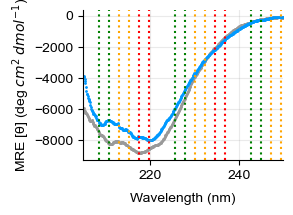

In [14]:
#plot single temperatures


lit_list = []
lit_temperature_list = []
dark_list = []
dark_temperature_list = []


ax = plt
a1 = ax.figure().add_axes([0,0,1,1])
a1.set_ylabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=2)
a1.set_xlabel("Wavelength (nm)", labelpad=8)
ax.grid("both", alpha=0.2)


#rcParams['lines.markersize'] = 1
#the range is for the temperatures in the set of files. 
for row in range(0,2):
#for row in range(len(master_list['Read 1'])):
#set files 
    spectra_1_name = master_list['Read 1'][row]
    spectra_1 = pd.read_csv(spectrum_path + spectra_1_name,header=None,skiprows=20,nrows=601)
    spectra_1.columns =['wavelength', 'CD', 'HT']

    spectra_2_name = master_list['Read 2'][row]
    spectra_2 = pd.read_csv(spectrum_path + spectra_2_name,header=None,skiprows=20,nrows=601)
    spectra_2.columns =['wavelength', 'CD', 'HT']

    spectra_3_name = master_list['Read 3'][row]
    spectra_3 = pd.read_csv(spectrum_path + spectra_3_name,header=None,skiprows=20,nrows=601)
    spectra_3.columns =['wavelength', 'CD', 'HT']
    #pull lit/dark  and temperature status
    temperature = master_list['Temp'][row]
    light = master_list['Light'][row]
    #data filter for light blips    
    spectra_1_jumps, spectra_1.CD = change_detector(spectra_1.wavelength.values, spectra_1.HT.values, spectra_1.CD)
    spectra_2_jumps, spectra_2.CD = change_detector(spectra_2.wavelength.values, spectra_2.HT.values, spectra_2.CD)
    spectra_3_jumps, spectra_3.CD = change_detector(spectra_3.wavelength.values, spectra_3.HT.values, spectra_3.CD)
    #average the 3
    spectra_merge = pd.concat([spectra_1, spectra_2, spectra_3]).groupby(level=0).mean()
    #plot
    
    x = spectra_merge.wavelength.values
    y = spectra_merge.HT.values
    ycd = cd_convert(spectra_merge.CD, 0.7, 0.1, 113.83)

    #ax.scatter(spectra_1.wavelength.values, spectra_1.HT.values, s=5)
    #ax[0,0].set(ylim=(-3, 5), ylabel="signal / curve", axisbelow=True)
    if light == 'Lit':
        ax.scatter(x[0:450], ycd.values[0:450], c="#0099FF", s=1)
        #continue
    else:
        ax.scatter(x[0:450], ycd.values[0:450], c="#999999", s=1)
        continue
    #ax.legend()
plt.gca().spines[['right', 'top']].set_visible(False)

for idx in spectra_1_jumps:
    ax.axvline(x[idx], ls=":", color="green")
for idx in spectra_2_jumps:
    ax.axvline(x[idx], ls=":", color="orange")
for idx in spectra_3_jumps:
    ax.axvline(x[idx], ls=":", color="red")

#ax.legend().set_visible(False)
if to_plot == 'yes':
    figure_name = "DL121_melt_spectra_15C_post_melt.pdf"
    plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
plt.xlim(205, 250)
plt.show()    

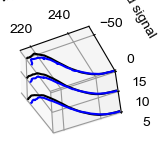

In [15]:
#multiple temperatures with a 3D plot

#set up plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_ylabel("cd signal")#, labelpad=8)
ax.set_xlabel("wavelength")#, labelpad=8)
ax.set_zlabel("Temperature")#, labelpad=8)


for row in range(0,6):
#set files 
    spectra_1_name = master_list['Read 1'][row]
    spectra_1 = pd.read_csv(spectrum_path + spectra_1_name,header=None,skiprows=20,nrows=601)
    spectra_1.columns =['wavelength', 'CD', 'HT']

    spectra_2_name = master_list['Read 2'][row]
    spectra_2 = pd.read_csv(spectrum_path + spectra_2_name,header=None,skiprows=20,nrows=601)
    spectra_2.columns =['wavelength', 'CD', 'HT']

    spectra_3_name = master_list['Read 3'][row]
    spectra_3 = pd.read_csv(spectrum_path + spectra_3_name,header=None,skiprows=20,nrows=601)
    spectra_3.columns =['wavelength', 'CD', 'HT']
    #pull lit/dark  and temperature status
    temperature = master_list['Temp'][row]
    light = master_list['Light'][row]
    #data filter for light blips    
    spectra_1_jumps, spectra_1.CD = change_detector(spectra_1.wavelength.values, spectra_1.HT.values, spectra_1.CD)
    spectra_2_jumps, spectra_2.CD = change_detector(spectra_2.wavelength.values, spectra_2.HT.values, spectra_2.CD)
    spectra_3_jumps, spectra_3.CD = change_detector(spectra_3.wavelength.values, spectra_3.HT.values, spectra_3.CD)
    #average the 3
    spectra_merge = pd.concat([spectra_1, spectra_2, spectra_3]).groupby(level=0).mean()
    #plot
    
    x = spectra_merge.wavelength.values
    y = spectra_merge.HT.values
    ycd = spectra_merge.CD

    if light == 'Lit':
        ax.plot3D(x[0:350], ycd.values[0:350], temperature, color='blue', label=temperature)
        #ax.plot3D(x[0:350], temperature, ycd.values[0:350], color='blue', label=temperature)
        #continue
    else:
        ax.plot3D(x[0:350], ycd.values[0:350], temperature, color='black', label=temperature)
        #ax.plot3D(x[0:350], temperature, ycd.values[0:350], color='black', label=temperature)
        #continue
    ax.legend()
ax.legend().set_visible(False)
            
ax.view_init(elev=-40, azim=-70, roll=5)

ax.set_ylim(-60, -0)
ax.set_xlim(215, 250)
plt.show()    


Now show temperature range on 3d plot that can be interacted with using a python widget (ipywidgets).  

In [16]:
def graph_widget(elev,azim,roll):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("Temperature (°C)", labelpad=10)
    ax.set_ylabel("Wavelength (nm)", labelpad=10)
    ax.set_zlabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=10)
    ax.grid("both", alpha=0.2)
    
    def plot_computer(row):
    #set files 
        spectra_1_name = master_list['Read 1'][row]
        spectra_1 = pd.read_csv(spectrum_path + spectra_1_name,header=None,skiprows=20,nrows=601)
        spectra_1.columns =['wavelength', 'CD', 'HT']
    
        spectra_2_name = master_list['Read 2'][row]
        spectra_2 = pd.read_csv(spectrum_path + spectra_2_name,header=None,skiprows=20,nrows=601)
        spectra_2.columns =['wavelength', 'CD', 'HT']
    
        spectra_3_name = master_list['Read 3'][row]
        spectra_3 = pd.read_csv(spectrum_path + spectra_3_name,header=None,skiprows=20,nrows=601)
        spectra_3.columns =['wavelength', 'CD', 'HT']
        #pull lit/dark  and temperature status
        temperature = master_list['Temp'][row]
        light = master_list['Light'][row]
        #data filter for light blips    
        spectra_1_jumps, spectra_1.CD = change_detector(spectra_1.wavelength.values, spectra_1.HT.values, spectra_1.CD)
        spectra_2_jumps, spectra_2.CD = change_detector(spectra_2.wavelength.values, spectra_2.HT.values, spectra_2.CD)
        spectra_3_jumps, spectra_3.CD = change_detector(spectra_3.wavelength.values, spectra_3.HT.values, spectra_3.CD)
        #average the 3
        spectra_merge = pd.concat([spectra_1, spectra_2, spectra_3]).groupby(level=0).mean()
        #plot
        
        x = spectra_merge.wavelength.values
        y = spectra_merge.HT.values
        ycd = cd_convert(spectra_merge.CD, 0.7, 0.1, 113.83)
        #ycd = spectra_merge.CD

        #build temperature value so I can 
        temperature_value = []
        for i in range(0,len(x[0:350])):
           temperature_value.append(temperature)
    
        if light == 'Lit':
            #ax.plot3D(x[0:350], ycd.values[0:350], temperature, color='blue', label=temperature)
            ax.plot3D(temperature_value, x[0:350], ycd.values[0:350], c="#0099FF", label=temperature)
            #continue
        else:
            #ax.plot3D(x[0:350], ycd.values[0:350], temperature, color='black', label=temperature)
            ax.plot3D(temperature_value, x[0:350], ycd.values[0:350], c="black", label=temperature)
            #continue
        ax.legend()

#    for row in range(0,36,2):
    for row in range(0,42,2):
        plot_computer(row)
        plot_computer(row+1)
    ax.legend().set_visible(False)
    
    ax.view_init(elev=elev, azim=azim, roll=roll)
    
    ax.invert_zaxis()

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.set_box_aspect((3, 2, 1))  # xyz aspect ratio 
    plt.rcParams["figure.figsize"] = [6.50, 6.50]
    ax.dist = 14
    #plt.tight_layout()
    
    if to_plot == 'yes':
        figure_name = "DL121_melt_spectra_all_3d.pdf"
        plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')

    plt.show()    

#This section is to save a gif of the rotations
    #def rotate(angle):
    #    ax.view_init(azim=angle)
    #rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 1), interval=100)
    #rot_animation.save('rotation.gif', dpi=180, writer='imagemagick')

In [18]:
#set up the sliders with the initial values
elev_slider = widgets.IntSlider(value=-30, min=-360, max=360, step=5, description='elev:')
azim_slider = widgets.IntSlider(value=225, min=-360, max=360, step=5, description='azim:')
roll_slider = widgets.IntSlider(value=180, min=-360, max=360, step=5, description='roll:')
#launch the widget. 
widgets.interact(graph_widget,elev=elev_slider,azim=azim_slider,roll=roll_slider);

interactive(children=(IntSlider(value=-30, description='elev:', max=360, min=-360, step=5), IntSlider(value=22…

222nm of the CD spectra corresponds to the alpha helix content of the protein. 
Here we take only the 222nm region at each temperature and plot them. 
This allows us to remove the 3rd wavelength dimension.

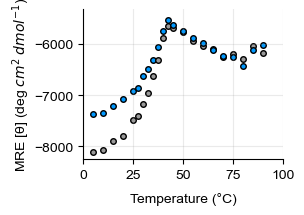

In [22]:
#change global font settings in plots: 
#the previous 3d plot widget changed them. 
rcParams['font.family'] = "Arial"
rcParams.update({"axes.grid" : True, "grid.color": "#999999"})
rcParams['lines.markersize'] = 4
rcParams.update({'font.size': 10})
rcParams["figure.figsize"] = (2,1.5)


#plot the spectra of each scan at a wavelength of 222nm. 
ax = plt
a1 = ax.figure().add_axes([0,0,1,1])
a1.set_ylabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=2)
a1.set_xlabel("Temperature (°C)", labelpad=8)
ax.grid("both", alpha=0.2)
#a1.set_ylim(-55, -30)
a1.set_xlim(0, 100)

lit_list = []
lit_temperature_list = []
dark_list = []
dark_temperature_list = []


#for row in range(0,8):
for row in range(len(master_list['Read 1'])):
#set files 
    spectra_1_name = master_list['Read 1'][row]
    spectra_1 = pd.read_csv(spectrum_path + spectra_1_name,header=None,skiprows=20,nrows=601)
    spectra_1.columns =['wavelength', 'CD', 'HT']

    spectra_2_name = master_list['Read 2'][row]
    spectra_2 = pd.read_csv(spectrum_path + spectra_2_name,header=None,skiprows=20,nrows=601)
    spectra_2.columns =['wavelength', 'CD', 'HT']

    spectra_3_name = master_list['Read 3'][row]
    spectra_3 = pd.read_csv(spectrum_path + spectra_3_name,header=None,skiprows=20,nrows=601)
    spectra_3.columns =['wavelength', 'CD', 'HT']
    #pull lit/dark  and temperature status
    temperature = master_list['Temp'][row]
    light = master_list['Light'][row]
    #data filter for light blips    
    spectra_1_jumps, spectra_1.CD = change_detector(spectra_1.wavelength.values, spectra_1.HT.values, spectra_1.CD)
    spectra_2_jumps, spectra_2.CD = change_detector(spectra_2.wavelength.values, spectra_2.HT.values, spectra_2.CD)
    spectra_3_jumps, spectra_3.CD = change_detector(spectra_3.wavelength.values, spectra_3.HT.values, spectra_3.CD)
    #average the 3
    spectra_merge = pd.concat([spectra_1, spectra_2, spectra_3]).groupby(level=0).mean()
    #plot
    
    x = spectra_merge.wavelength.values
    y = spectra_merge.HT.values
    ycd = cd_convert(spectra_merge.CD, 0.7, 0.1, 113.83)

    #ax.scatter(spectra_1.wavelength.values, spectra_1.HT.values, s=5)
    #ax[0,0].set(ylim=(-3, 5), ylabel="signal / curve", axisbelow=True)
    if light == 'Lit':
        i = 0
        mean_lit_counter = 0
        alpha_lit_mean = 0
        for x in spectra_merge.wavelength:
            i = i + 1
            #if 240 <= x < 241:
            if 222 <= x < 223:
                #print(x)
                #print(spectra_merge.CD[i-1])
                alpha_lit_mean = alpha_lit_mean + ycd[i-1]
                mean_lit_counter = mean_lit_counter + 1
        alpha_lit_mean = np.divide(alpha_lit_mean, mean_lit_counter)
        ax.scatter(temperature, alpha_lit_mean, c="#0099FF" , edgecolors='black', label=light)
        lit_list.append(alpha_lit_mean)
        lit_temperature_list.append(temperature)
        #continue
    else:
        i = 0
        mean_dark_counter = 0
        alpha_dark_mean = 0
        for x in spectra_merge.wavelength:
            i = i + 1
            #if 240 <= x < 241:
            if 222 <= x < 223:
                alpha_dark_mean = alpha_dark_mean + ycd[i-1]
                mean_dark_counter = mean_dark_counter + 1
        alpha_dark_mean = np.divide(alpha_dark_mean, mean_dark_counter)
        ax.scatter(temperature, alpha_dark_mean, c="#999999" , edgecolors='black', label=light)
        #ax.scatter(temperature, alpha_lit_mean, color='black', label=temperature)
        dark_list.append(alpha_dark_mean)
        dark_temperature_list.append(temperature)
        continue
    ax.legend()
plt.gca().spines[['right', 'top']].set_visible(False)

ax.legend().set_visible(False)
if to_plot == 'yes':
    figure_name = "DL121_melt_spectra_all.pdf"
    plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')

plt.show()    

The difference between the lit and dark 222nm signal can be thought of as a proxy for the allosteric effect. 
How does it change with temperature? 
We observe that it is strongest at low temperatures and is eliminated at 50C. 
This is also generally true for catalysis. 

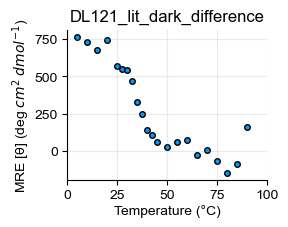

In [23]:
#now plot the lit-dark difference of the 222nm spectral scans at different temperatures. 
delta_cd = np.subtract(lit_list, dark_list)
#delta_cd = np.divide(dark_list, lit_list)
ax = plt
a1 = ax.figure().add_axes([0,0,1,1])
a1.set_ylabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=2, fontsize=10)
a1.set_xlabel("Temperature (°C)", labelpad=2, fontsize=10)
ax.grid("both", alpha=0.2)
#a1.set_ylim(-55, -30)
a1.set_xlim(0, 100)
ax.scatter(lit_temperature_list, delta_cd, c="#0099FF" , edgecolors='black', label=light)
ax.legend()
ax.legend().set_visible(False)
title = ("DL121_lit_dark_difference")
plt.title(title)
#save the plot out
if to_plot == 'yes':
    figure_name = ('%s.pdf' % title)
    plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
plt.gca().spines[['right', 'top']].set_visible(False)        
plt.show()

We have also collected the thermal melt of DL121 and some mutants at 222nm and 222.1nm on the Jasco J-815 CD Spectrometer (see methods for more details). 
through fitting a curve we can determine the Tm: the temperature of the protein where it is 50% unfolded. 

Details on the curve fitting:

A two-state transition of a monomer between folded and unfolded forms with correcting the
data for pre- and post-transition linear changes in ellipticity as a function of temperature.

formula from https://www.nature.com/articles/nprot.2006.204
https://static-content.springer.com/esm/art%3A10.1038%2Fnprot.2006.204/MediaObjects/41596_2006_BFnprot2006204_MOESM1_ESM.pdf

This function will also plot the MRE with the fit applied, and print out the statistics of the fit.  to w e CD etc 

In [24]:
def nature_method(xdata_all, ydata_all, end,to_plot,melt_mutant,light_state,initial_guess,fit_bounds):
    
    
    # Three state boltzmann sigmoidal with different tops and bottoms
    def nature_sigmoid(v, h, tm, bottom1, top1, u1, l1):
        #h;starting enthalpy 
        #tm;starting TM
        #bottom1;Mean Residue Ellipticity 100% folded
        #top1;Mean Residue Ellipticity 100% unfolded
        #l;Mean Residue Ellipticity 100% unfolded
        #u1;linear correction folded function of temp
        #l1;linear correction unfolded function of temp 
        
        #v=col(1) ;temperature 
        #w=col(2) ;absorbance CD etc
        
        m=tm+273.15
        t=np.add(v,273.15)
        #calculate folding constant at any given temperature
        k=np.exp((h/(1.987*t))*((t/m)-1))
        #calculate fraction folded at any given temperature
        f=k/(1+k)  
        #calculate ellipticity at any given temperature 
        y=f*((bottom1+np.multiply(u1,v))-(top1+np.multiply(l1,v)))+ (top1+np.multiply(l1,v)) 
        #fit y to w 


        return y
        
    xdata = xdata_all[0:end]
    ydata = ydata_all[0:end]
    

    #Maximum number of function evaluations before the termination.
    max_nfev=None 
    #max_nfev=10000000 
    
    #curve fitting function. 
    popt, pcov = curve_fit(nature_sigmoid, xdata, ydata, bounds=(fit_bounds),\
                           p0=initial_guess, absolute_sigma=True,method='trf', maxfev=max_nfev)

    #print(popt)
    ###calculate r squared
    
    #get the residual sum of squares (ss_res) 
    residuals = ydata- nature_sigmoid(xdata, *popt)
    ss_res = np.sum(residuals**2)
    
    #get the total sum of squares (ss_tot) 
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    #the r_squared-value
    r_squared = 1 - (ss_res / ss_tot)
    ####
    
    starting_enthalpy, estimated_v501, minimum1, maximum1, correction_folded, correction_unfolded = popt
    perr = np.sqrt(np.diag(pcov))
    #y_fitted = sigmoid(x, k=estimated_k, x0=estimated_x0)
    title = (melt_mutant + ' ' + light_state)
    print('nature_method: %s' % title)
    print('starting enthalpy = %.2f, \u03C3 = %.2f' % (starting_enthalpy,perr[0] ))
    print('TM1 = %.2f, \u03C3 = %.2f' % (estimated_v501,perr[1] ))
    print('Top = %.2f, \u03C3 = %.2f' % (maximum1,perr[3] ))
    print('Bottom = %.2f, \u03C3 = %.2f' % (minimum1,perr[2] ))
    print('correction folded = %.2f, \u03C3 = %.2f' % (correction_folded,perr[4] ))
    print('correction unfolded = %.2f, \u03C3 = %.2f' % (correction_unfolded,perr[5] ))
    print('R\u00b2 = %.4f' % (r_squared))
   
    # Plot the fitted curve
    #x = np.linspace(5, 80, 100)
    x = np.linspace(5, xdata_all[end], 100)
    y = nature_sigmoid(x, *popt)
    
    ax = plt
    a1 = ax.figure().add_axes([0,0,1,1])
    if light_state == 'Lit':
        ax.scatter(xdata_all, ydata_all, c="#0099FF" , edgecolors='black')
    else:
        ax.scatter(xdata_all, ydata_all, c="#999999" , edgecolors='black')

    
    #pylab.plot(xdata_all, ydata_all, 'o')#, label='data')
    pylab.plot(x,y, label='Two State Fit', color="red")
    a1.set_ylabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=2)
    a1.set_xlabel("Temperature (°C)", labelpad=2)
    ax.axvline(estimated_v501, ls=":", color="green", label=('$T_M$ = %.2f, \u03C3 = %.2f' % (estimated_v501,perr[1] )))
    ax.grid("both", alpha=0.2)
    #ax.set_title(title)
    #pylab.ylim(0, 1.05)
    #pylab.legend(loc='best')
    pylab.xlim(0, 100)
    pylab.ylim(-8000,-4000)
    #pylab.show()
    plt.gca().spines[['right', 'top']].set_visible(False)    

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_melt.pdf' % title)
        plt.savefig('./output/CD_curves/two_state_%s' % figure_name, bbox_inches='tight')

    plt.show()
    return starting_enthalpy, perr[0], estimated_v501, perr[1], maximum1, perr[3], minimum1, perr[2],\
    correction_folded, perr[4], correction_unfolded, perr[5],r_squared

In [25]:
#load the list of all the file names and information for the melt experiments. 
melt_path = './input_data/melt/'
melt_list = pd.read_csv(melt_path + 'list.csv',header=(0))
melt_list

,Mutant,Light,Read 222,Nrows_1,Concentration_1,Read 222.1,Nrows_2,Concentration_2,MolWeight
0,DL121,Dark,DL121-Dark-1-222nm.csv,120,1.0650,DL121-Dark-1-222.1nm.csv,120,1.0650,NaN
1,DL121,Lit,Dl121-lit-222nm_020823.csv,131,1.0650,Dl121-lit-221nm_020823.csv,131,1.0650,NaN
2,D87A,Dark,D87A-dark-1-222nm.csv,131,0.9290,D87A-dark-1-222.1nm.csv,131,0.9290,NaN
3,D87A,Lit,D87A-lit-1-222nm.csv,131,0.9290,D87A-lit-1-222.1nm.csv,131,0.9290,NaN
4,M16P,Dark,M16P-Dark-1-222nm.csv,131,1.6000,M16P-Dark-1-222.1nm.csv,131,1.6000,NaN
5,M16P,Lit,M16P-Lit-1-222nm.csv,131,1.6000,M16P-Lit-1-222.1nm.csv,131,1.6000,NaN
6,M16A,Dark,M16A-Dark-1-222nm.csv,131,1.7000,M16A-Dark-1-222.1nm.csv,131,1.7000,NaN
7,M16A,Lit,M16A-Lit-1-222nm.csv,127,1.7000,M16A-Lit-1-222.1nm.csv,127,1.7000,NaN
8,DL116,Dark,DL116_Dark_Melt_222.csv,111,NaN,DL116_Dark_Melt_222_1.csv,111,NaN,NaN
9,DL116,Lit,DL116_Lit_Melt_222.csv,141,NaN,DL116_Lit_Melt_222_1.csv,141,NaN,NaN


NOTE. 

C450S uses the same file for 222.0nm and 222.1nm. This is because C450S was an early mutant screend before all parameters were set:
where the melt was observed at 222.0nm and 217nm. 217 is different enough that it changes the data when averaging. Feeding the same file twice does not change the statistics vs one file. This is because the two files are scanned for lit blips (def melt_change_detector). The blips are replaced with NaN, and then the two files are averaged and treated as one list. With two different files this should (and does in every case) mean that when one entry is NaN, the other entry has a number, so that every temperature step has a value. C450S does not, and thus has NaNs and less entries to fit, resulting in a lower confidence of fit. I simply supply the same file twice for simplicity in the code. 

Melt change detector:

This section of code is to look for light blips. It is constructed differently than the light blip detector for scanning spectral reads above because a light blip happening at the same time as one read does not alter the reads at a different temperature (separated by minutes). Therefore ANY dramatic change in the HV signal is considered as due to a light blip. 

Note that the dark state of the protein does precipitate and have strong HV jumps as a result. The melt change detector does not try and filter these blips (or anything) from the dark state for this reason. I can not find any examples of non-lit blips being cleaned out to bias the sample in the light samples. Running the detector on the dark sample which would preserve the precipiptation and high temperature HV jumps, but still clean out light blips would require significant changes for zero functional results. 

In [28]:
#lets make it a function
def melt_change_detector(x, y, ycd): 
    #x = melt.TEMPERATURE.values
    #y = melt.HT.values
    #ycd = melt_1.CD

    jump_idxs = []
##computes the difference between the two elements y[i+1] - y[i]
    #this is not sensitive to situations where there are multiple light blips together. 
    deriv = np.diff(y, n=1)
## compute the first derivative to identify jumps in HV value (not used)
    #deriv = np.gradient(y)

    ## find index locations of jumps
    #jump 1 is sensitive to the pulse of light which lowers the HT signal. 
    jump_threshold_1 = -5.0 
    #jump 2 is sensitive to a blipped point returning to dark, that would be an increase in HV. 
    jump_threshold_2 = 5.0
    #jump_idxs_temp = np.where(np.abs(deriv)>jump_threshold)[0]
    jump_idxs_1 = np.where(deriv<jump_threshold_1)[0]
    jump_idxs_2 = np.where(deriv>jump_threshold_2)[0]
    for i in ycd.index:
            if i in jump_idxs_1:
                #this adds one to the index because light lowers hv signal. If |a|-|b| < 0 then b is the light blip
                ycd.values[i+1] = "NaN"
                jump_idxs.append(i+1)
                #this uses index because light lowers hv signal. If |a|-|b| > 0 then a is the light blip                
            if i in jump_idxs_2:
                ycd.values[i] = "NaN"
                jump_idxs.append(i)
    return jump_idxs, ycd

This function is to read the file, apply melt_change_detector to detect and clean out light blips, plot the HT_signal, 
convert CD to MRE with cd_convert, and plot the MRE.

In [29]:
#this is to read in the melt @222nm and 222.1 experiments, and then clean out the lit bloops 
def melt_cycler(row, to_plot, melt_path, melt_list):
#for row in range(len(melt_list['Read 222'])):
#set files 
    #name of csv file
    melt_1_jumps = []
    melt_2_jumps = []

    concentration = melt_list['Concentration_1'][row] 
    #if there is no concentration in file, then change it to equal that of DL121 (workaround)
    #this works because nan equals no values, including itself. 
    if concentration != concentration:
        concentration = melt_list['Concentration_1'][0] 
    melt_1_name = melt_list['Read 222'][row] 
    # after how many rows does the data start (eg data starts on 16, put 15)
    nrows_1 = melt_list['Nrows_1'][row] 
    #skiprows skips the headers to data
    melt_1 = pd.read_csv(melt_path + melt_1_name,header=None,skiprows=15,nrows=nrows_1)
    #assign headers to the columns, as there is no label in the csv
    melt_1.columns =['TEMPERATURE', 'CD', 'HT']

    melt_2_name = melt_list['Read 222.1'][row]
    nrows_2 = melt_list['Nrows_2'][row]
    melt_2 = pd.read_csv(melt_path + melt_2_name,header=None,skiprows=15,nrows=nrows_2)
    melt_2.columns =['TEMPERATURE', 'CD', 'HT']

    #pull lit/dark  and temperature status
    melt_mutant = melt_list['Mutant'][row]
    light_state = melt_list['Light'][row]
    
    #data filter for light blips
    if light_state == 'Lit':
        #print(melt_1.CD)
        melt_1_jumps, melt_1.CD = melt_change_detector(melt_1.TEMPERATURE.values, melt_1.HT.values, melt_1.CD)
        #print(melt_1.CD)
        melt_2_jumps, melt_2.CD = melt_change_detector(melt_2.TEMPERATURE.values, melt_2.HT.values, melt_2.CD)
    #average the 3
    melt_merge = pd.concat([melt_1, melt_2]).groupby(level=0).mean()
    #remove rows with nan
    melt_merge = melt_merge.dropna()
    #                      (CD_values, sample_concentration (mg/ml), cell_pathlength (cm), mean molecular_weight (da) )
    CD_values = cd_convert(melt_merge.CD, concentration, 0.1, 113.83)
        #ycd = spectra_merge.CD
    
    
    #plot
    x = melt_merge.TEMPERATURE.values
    y = melt_merge.HT.values
    ycd = CD_values

    ax = plt
    a1 = ax.figure().add_axes([0,0,1,1])
    #ax.scatter(spectra_1.wavelength.values, spectra_1.HT.values, s=5)
    #ax[0,0].set(ylim=(-3, 5), ylabel="signal / curve", axisbelow=True)
    plt.gca().spines[['right', 'top']].set_visible(False)
    if light_state == 'Lit':
        ax.scatter(melt_1.TEMPERATURE.values, melt_1.HT.values, color='#0099FF', edgecolors='black', label="HT_signal_1")
        #ax.scatter(melt_2.TEMPERATURE.values, melt_2.HT.values, c="#0099FF" , edgecolors='none', label="HT_signal_2")
    else:
        ax.scatter(melt_1.TEMPERATURE.values, melt_1.HT.values, c="#999999" , edgecolors='black', label="HT_signal_1")
        #ax.scatter(melt_2.TEMPERATURE.values, melt_2.HT.values, color='black', edgecolors='none', label="HT_signal_2")
    a1.set_ylabel("Photo-Multiplier Voltage (V)", labelpad=15)
    a1.set_xlabel("Temperature (°C)", labelpad=2)
    ax.grid("both", alpha=0.2)
    #a1.set_ylim(-60, 20)
    a1.set_xlim(0, 100)
    for idx in melt_1_jumps:
        ax.axvline(melt_1.TEMPERATURE.values[idx], ls=":", color="black")
    #for idx in melt_2_jumps:
        #ax.axvline(melt_2.TEMPERATURE.values[idx], ls=":", color="black")
    #ax.legend()
    title = (melt_mutant + ' ' + light_state)
    print(title)
    #plt.title(title)
    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_HT_signal.pdf' % title)
        plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
        
    plt.show()

    ax = plt
    a1 = ax.figure().add_axes([0,0,1,1])
    #ax.scatter(spectra_1.wavelength.values, spectra_1.HT.values, s=5)
    #ax[0,0].set(ylim=(-3, 5), ylabel="signal / curve", axisbelow=True)
    #ax.scatter(x, ycd.values, color='blue')
    ax.scatter(x, ycd.values, c="#0099FF" , edgecolors='none')
    #ax.scatter(melt_1.TEMPERATURE.values, melt_1.CD, color='blue', label="cd_signal_1")
    #ax.scatter(melt_2.TEMPERATURE.values, melt_2.CD, color='black', label="cd_signal_2")
    a1.set_ylabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=2)
    a1.set_xlabel("Temperature (°C)", labelpad=2)
    ax.grid("both", alpha=0.2)
    #a1.set_ylim(-60, 20)
    a1.set_xlim(0, 100)
    for idx in melt_1_jumps:
        ax.axvline(melt_1.TEMPERATURE.values[idx], ls=":", color="blue")
    for idx in melt_2_jumps:
        ax.axvline(melt_2.TEMPERATURE.values[idx], ls=":", color="black")
    #ax.legend()

    #save the plot out
    if to_plot == 'yes':
        figure_name = ('%s_CD_Signal.pdf' % title)
        plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
    #plt.title(title)
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.show()  

    return melt_mutant, light_state, melt_merge, CD_values

This cell loops through all the different mutants in list.csv, run melt_cycler, melt_change_detector, and nature_method to plot the 
HV signal vs temp, MRE vs temp, as well as fit and plot the sigmoid, saving the Tm, error and fit paramaters to melt_df.

DL121 Dark


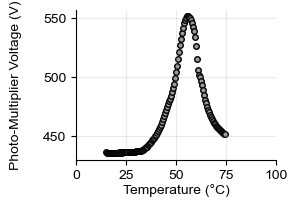

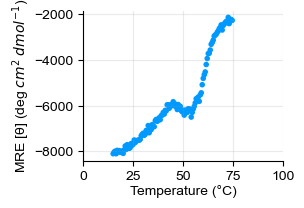

35.5
-8101.265067605633
-5829.656486384976
60
45.0
nature_method: DL121 Dark
starting enthalpy = -33487.43, σ = 145.30
TM1 = 35.14, σ = 0.03
Top = -4663.73, σ = 36.75
Bottom = -8131.82, σ = 4.76
correction folded = 2.00, σ = 0.38
correction unfolded = -23.29, σ = 0.68
R² = 0.9801


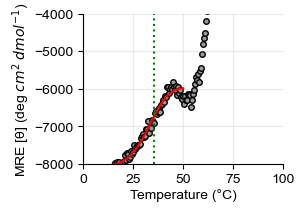

DL121 Lit


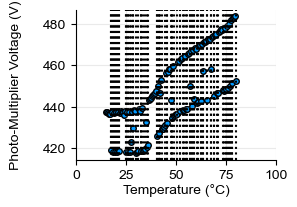

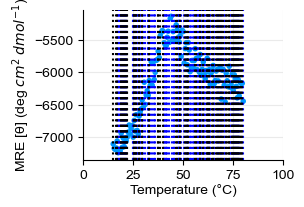

34.49
-7238.422979342724
-5139.985633802818
58
43.985
nature_method: DL121 Lit
starting enthalpy = -52041.63, σ = 74.72
TM1 = 33.46, σ = 0.01
Top = -4111.99, σ = 3.48
Bottom = -7148.53, σ = 2.29
correction folded = 2.00, σ = 0.13
correction unfolded = -29.16, σ = 0.07
R² = 0.9527


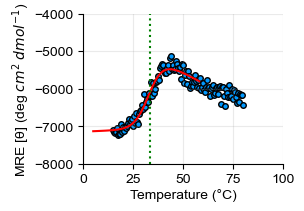

D87A Dark


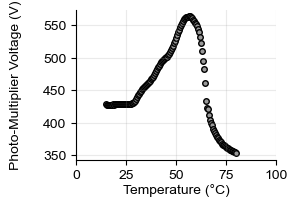

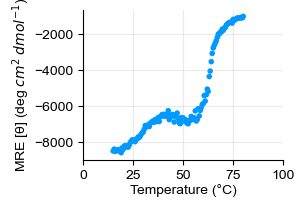

29.99
-8617.874477933261
-6264.901777179763
55
42.5
nature_method: D87A Dark
starting enthalpy = -42280.95, σ = 104.67
TM1 = 30.83, σ = 0.01
Top = -5011.92, σ = 11.23
Bottom = -8611.95, σ = 4.95
correction folded = 2.00, σ = 0.36
correction unfolded = -33.63, σ = 0.23
R² = 0.9772


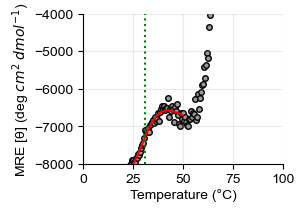

D87A Lit


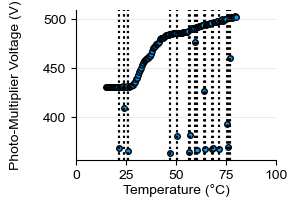

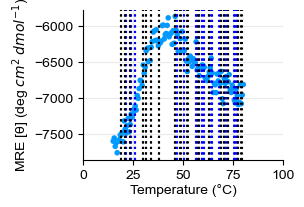

29.48
-7761.61311517761
-5859.377807319698
62
45.99
nature_method: D87A Lit
starting enthalpy = -48740.59, σ = 66.57
TM1 = 30.04, σ = 0.01
Top = -4687.50, σ = 1.87
Bottom = -7688.73, σ = 3.56
correction folded = 2.00, σ = 0.23
correction unfolded = -32.17, σ = 0.03
R² = 0.9613


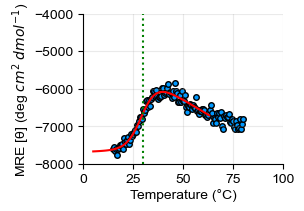

M16P Dark


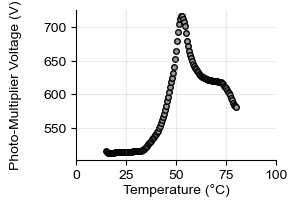

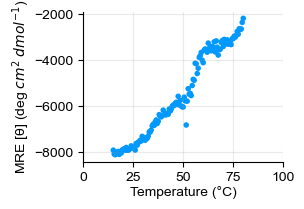

35.51
-8111.134509374999
-5574.151941562499
65
47.48
nature_method: M16P Dark
starting enthalpy = -36887.44, σ = 137.29
TM1 = 35.50, σ = 0.03
Top = -5573.91, σ = 32.60
Bottom = -8088.65, σ = 3.75
correction folded = 2.00, σ = 0.27
correction unfolded = -2.33, σ = 0.61
R² = 0.9843


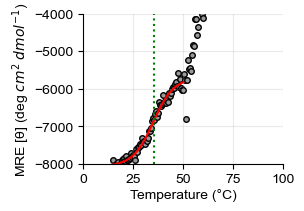

M16P Lit


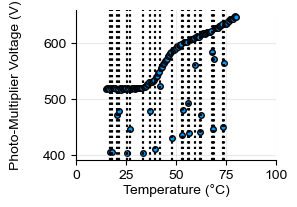

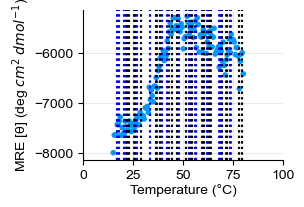

35.48
-7987.273240624998
-5280.776459687499
74
51.98
nature_method: M16P Lit
starting enthalpy = -52991.05, σ = 50.79
TM1 = 37.86, σ = 0.00
Top = -4224.62, σ = 2.75
Bottom = -7569.04, σ = 1.40
correction folded = 2.00, σ = 0.07
correction unfolded = -24.12, σ = 0.05
R² = 0.9675


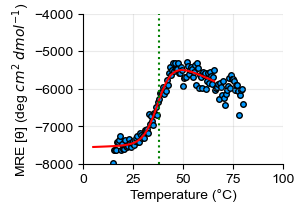

M16A Dark


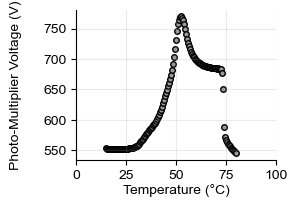

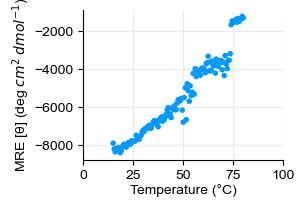

38.0
-8414.648394117647
-4977.702201470588
72
51.01
nature_method: M16A Dark
starting enthalpy = -20425.89, σ = 246.41
TM1 = 37.19, σ = 0.13
Top = -3982.16, σ = 150.86
Bottom = -8553.71, σ = 6.71
correction folded = -2.00, σ = 1.40
correction unfolded = -22.50, σ = 2.28
R² = 0.9200


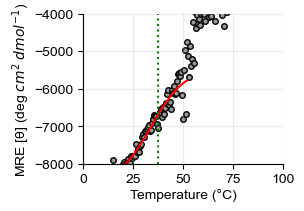

M16A Lit


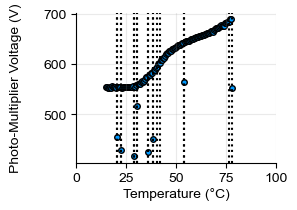

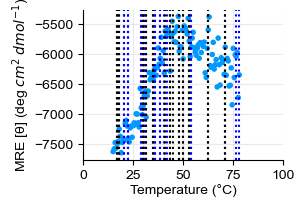

28.49
-7641.006147058823
-5369.990512941175
65
47.51
nature_method: M16A Lit
starting enthalpy = -39462.73, σ = 61.94
TM1 = 34.57, σ = 0.01
Top = -4295.99, σ = 4.26
Bottom = -7543.03, σ = 2.76
correction folded = 2.00, σ = 0.18
correction unfolded = -27.32, σ = 0.07
R² = 0.9343


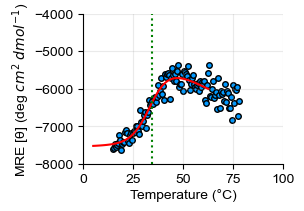

DL116 Dark


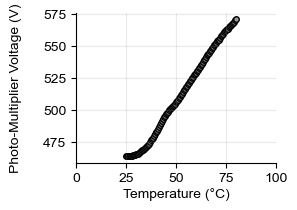

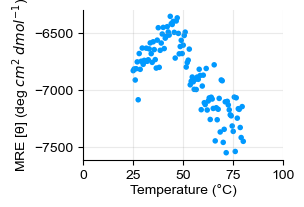

34.49
-7174.480446478875
-6357.742180281691
37
43.52
nature_method: DL116 Dark
starting enthalpy = -88373.62, σ = 468.84
TM1 = 39.44, σ = 0.02
Top = -5086.19, σ = 2.34
Bottom = -6835.19, σ = 3.95
correction folded = 2.00, σ = 0.14
correction unfolded = -31.71, σ = 0.04
R² = 0.6958


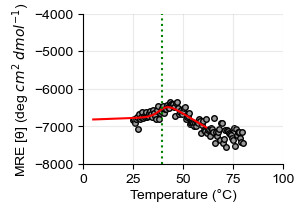

DL116 Lit


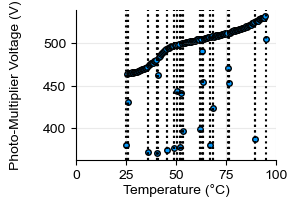

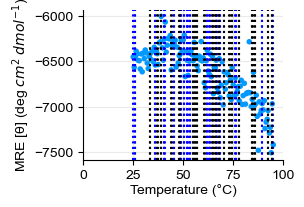

27.0
-6857.097823474179
-6000.914523004695
28
39.01
nature_method: DL116 Lit
starting enthalpy = -150000.00, σ = 1242.86
TM1 = 37.54, σ = 0.01
Top = -5737.76, σ = 1.13
Bottom = -6444.85, σ = 3.06
correction folded = -1.02, σ = 0.11
correction unfolded = -13.21, σ = 0.02
R² = 0.3521


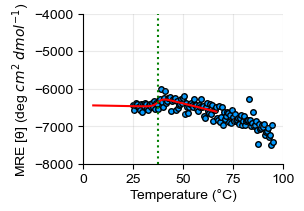

A9N Dark


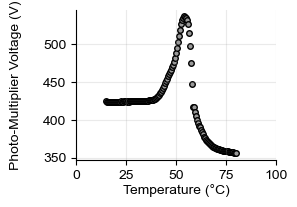

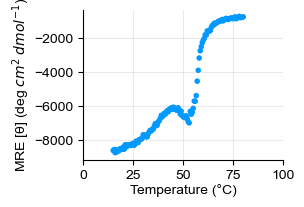

33.49
-8737.998191578947
-6057.95471631579
60
44.99
nature_method: A9N Dark
starting enthalpy = -39730.42, σ = 106.95
TM1 = 35.84, σ = 0.02
Top = -4846.36, σ = 30.11
Bottom = -8599.11, σ = 3.33
correction folded = 2.00, σ = 0.22
correction unfolded = -22.53, σ = 0.58
R² = 0.9862


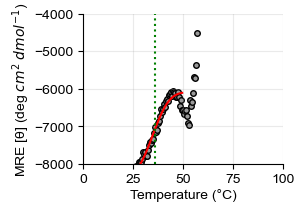

A9N Lit


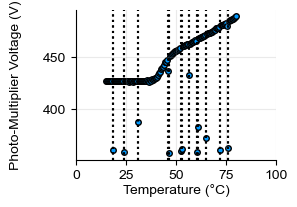

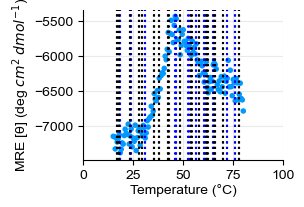

38.49
-7381.000806315789
-5434.73546631579
62
46.01
nature_method: A9N Lit
starting enthalpy = -77708.53, σ = 87.97
TM1 = 38.49, σ = 0.00
Top = -4347.79, σ = 2.26
Bottom = -7211.53, σ = 0.99
correction folded = 2.00, σ = 0.04
correction unfolded = -29.34, σ = 0.04
R² = 0.9546


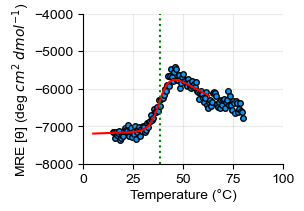

G86K Dark


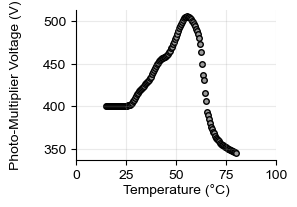

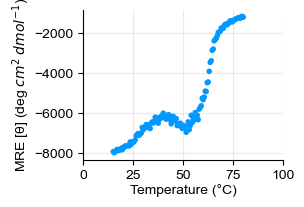

28.99
-7974.2054272727255
-5996.497875974024
50
40.0
nature_method: G86K Dark
starting enthalpy = -42309.97, σ = 131.89
TM1 = 29.75, σ = 0.02
Top = -4797.20, σ = 12.13
Bottom = -8012.84, σ = 5.99
correction folded = 2.00, σ = 0.45
correction unfolded = -32.34, σ = 0.25
R² = 0.9732


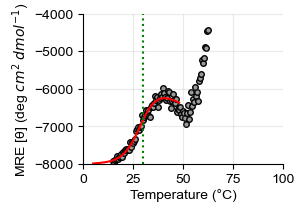

G86K Lit


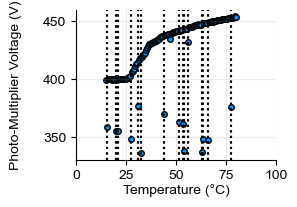

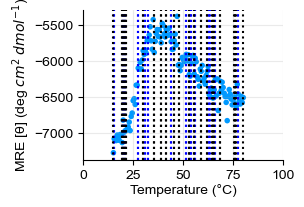

26.48
-7272.70218181818
-5386.8273525974
64
46.95
nature_method: G86K Lit
starting enthalpy = -60899.78, σ = 77.62
TM1 = 27.79, σ = 0.01
Top = -4454.11, σ = 1.21
Bottom = -7113.70, σ = 3.88
correction folded = -2.00, σ = 0.24
correction unfolded = -29.24, σ = 0.02
R² = 0.9460


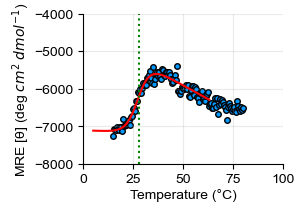

D116M Dark


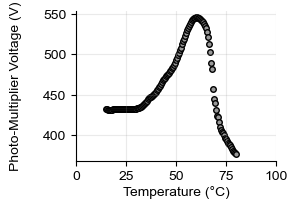

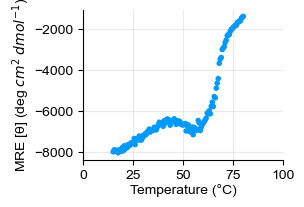

30.49
-8027.043353723406
-6373.5051792553195
61
45.49
nature_method: D116M Dark
starting enthalpy = -33838.82, σ = 139.70
TM1 = 32.25, σ = 0.03
Top = -5098.80, σ = 15.28
Bottom = -8072.25, σ = 5.59
correction folded = 2.00, σ = 0.46
correction unfolded = -28.84, σ = 0.28
R² = 0.9689


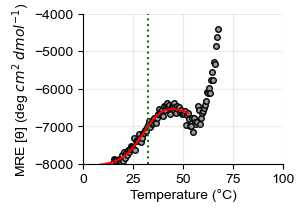

D116M Lit


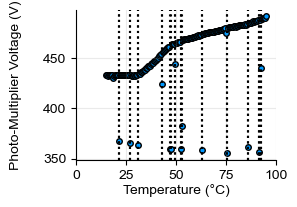

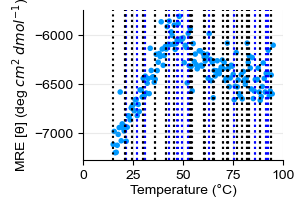

31.99
-7195.230628723404
-5813.013525
66
48.01
nature_method: D116M Lit
starting enthalpy = -33259.09, σ = 80.21
TM1 = 33.22, σ = 0.04
Top = -5141.25, σ = 2.66
Bottom = -7116.39, σ = 3.51
correction folded = 2.00, σ = 0.25
correction unfolded = -18.22, σ = 0.04
R² = 0.8469


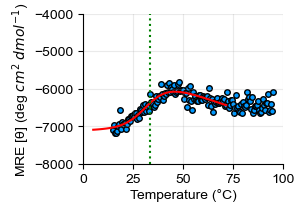

C450S Dark


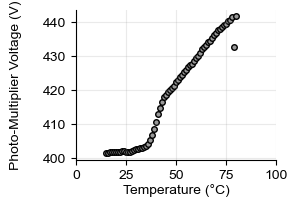

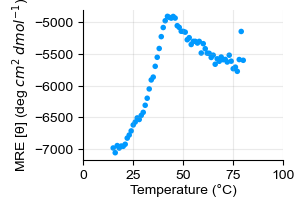

32.99
-7056.253402
-4905.572147999999
27
42.12
nature_method: C450S Dark
starting enthalpy = -57428.60, σ = 90.57
TM1 = 34.40, σ = 0.01
Top = -3924.46, σ = 3.66
Bottom = -6938.11, σ = 2.44
correction folded = 2.00, σ = 0.13
correction unfolded = -23.73, σ = 0.07
R² = 0.9829


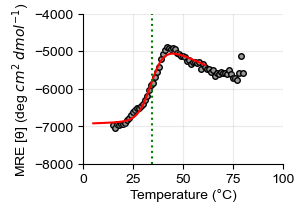

C450S Lit


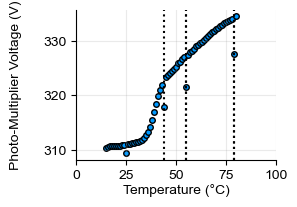

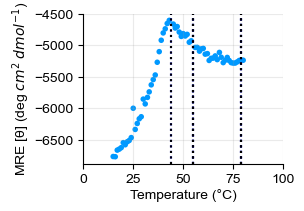

32.99
-6767.2276489999995
-4602.010304
28
43.02
nature_method: C450S Lit
starting enthalpy = -48988.72, σ = 87.15
TM1 = 34.00, σ = 0.01
Top = -3681.61, σ = 4.17
Bottom = -6665.19, σ = 3.02
correction folded = 2.00, σ = 0.18
correction unfolded = -22.34, σ = 0.07
R² = 0.9764


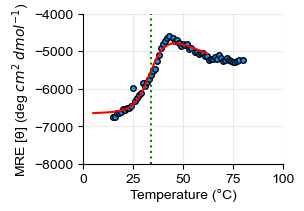

R98M Dark


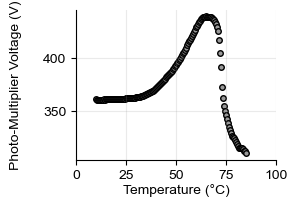

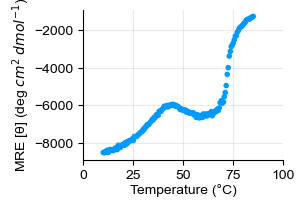

30.01
-8509.049742937852
-5946.549941807909
69
44.51
nature_method: R98M Dark
starting enthalpy = -37985.06, σ = 57.30
TM1 = 31.96, σ = 0.01
Top = -4757.24, σ = 7.14
Bottom = -8430.92, σ = 1.64
correction folded = 2.00, σ = 0.15
correction unfolded = -26.84, σ = 0.13
R² = 0.9881


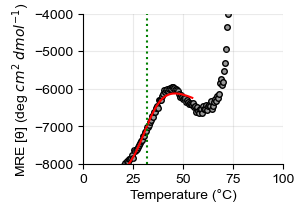

R98M Lit


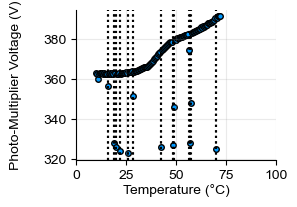

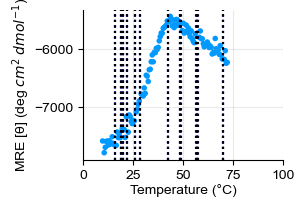

35.51
-7800.197534463276
-5431.285906214689
67
46.98
nature_method: R98M Lit
starting enthalpy = -41982.39, σ = 52.30
TM1 = 32.86, σ = 0.01
Top = -4345.03, σ = 3.94
Bottom = -7646.50, σ = 1.32
correction folded = 2.00, σ = 0.10
correction unfolded = -24.51, σ = 0.07
R² = 0.9892


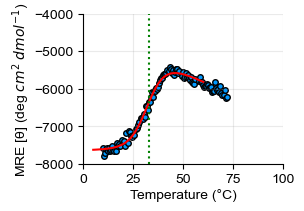

D127W Dark


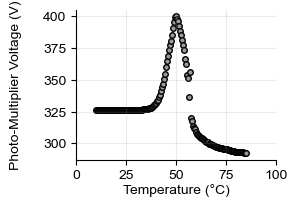

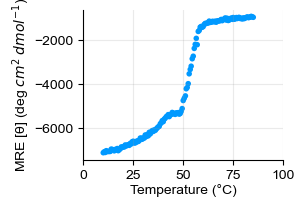

34.0
-7130.046855450236
-5242.375013428119
78
48.98
nature_method: D127W Dark
starting enthalpy = -25846.43, σ = 165.94
TM1 = 37.96, σ = 0.15
Top = -4193.90, σ = 92.87
Bottom = -7126.98, σ = 2.06
correction folded = 2.00, σ = 0.31
correction unfolded = -11.88, σ = 1.60
R² = 0.9908


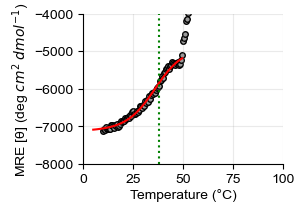

D127W Lit


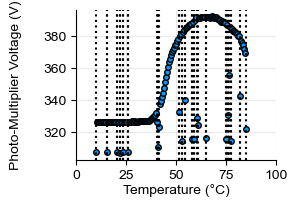

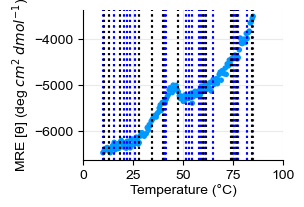

36.01
-6461.659753554501
-4854.328003949446
113
66.52
nature_method: D127W Lit
starting enthalpy = -61182.64, σ = 108.46
TM1 = 34.08, σ = 0.01
Top = -5572.46, σ = 1.48
Bottom = -6356.26, σ = 0.79
correction folded = 2.00, σ = 0.05
correction unfolded = 8.31, σ = 0.03
R² = 0.9698


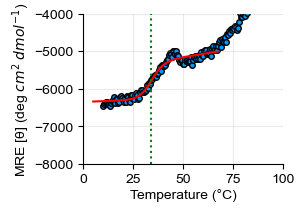

H124Q Dark


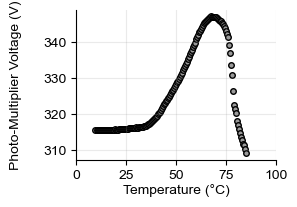

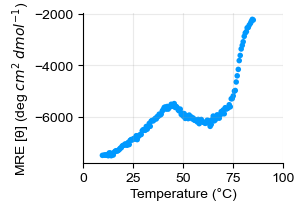

30.0
-7510.261637168141
-5488.494772123893
71
45.51
nature_method: H124Q Dark
starting enthalpy = -37034.57, σ = 67.22
TM1 = 31.77, σ = 0.01
Top = -4390.80, σ = 5.68
Bottom = -7463.68, σ = 1.65
correction folded = 2.00, σ = 0.15
correction unfolded = -27.99, σ = 0.10
R² = 0.9721


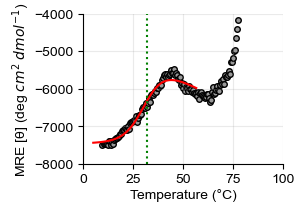

H124Q Lit


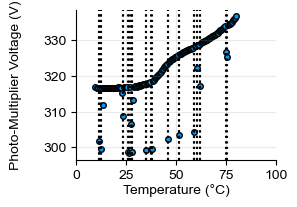

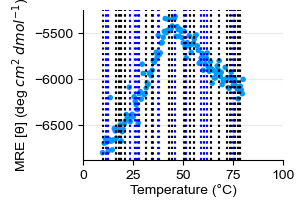

32.51
-6795.751734513273
-5321.602867256636
72
45.98
nature_method: H124Q Lit
starting enthalpy = -37128.64, σ = 73.21
TM1 = 34.04, σ = 0.01
Top = -4257.28, σ = 3.68
Bottom = -6658.41, σ = 1.32
correction folded = 2.00, σ = 0.11
correction unfolded = -24.60, σ = 0.06
R² = 0.9431


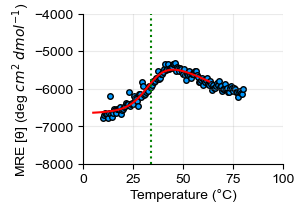

DL116_2 Dark


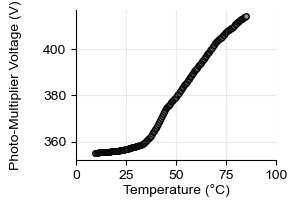

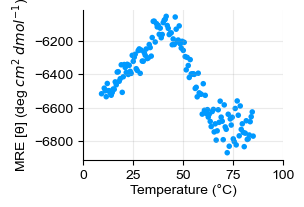

21.01
-6656.842704068411
-6052.930160663383
63
41.49
nature_method: DL116_2 Dark
starting enthalpy = -36997.34, σ = 151.78
TM1 = 36.18, σ = 0.03
Top = -4842.34, σ = 3.28
Bottom = -6500.87, σ = 1.20
correction folded = 2.00, σ = 0.10
correction unfolded = -28.40, σ = 0.06
R² = 0.8918


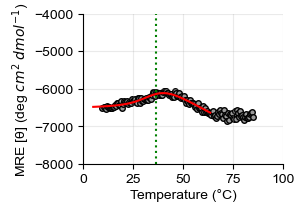

DL116_2 Lit


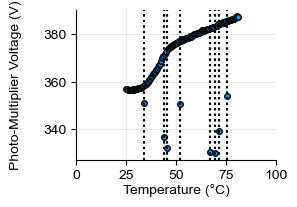

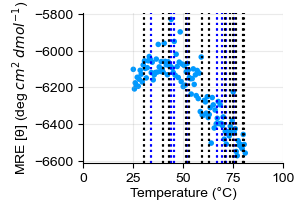

32.02
-6352.239051567761
-5828.352626328063
38
43.99
nature_method: DL116_2 Lit
starting enthalpy = -18594.18, σ = 932.73
TM1 = 43.99, σ = 1.96
Top = -4662.68, σ = 170.15
Bottom = -6315.15, σ = 33.46
correction folded = 0.75, σ = 3.38
correction unfolded = -26.55, σ = 2.16
R² = 0.4845


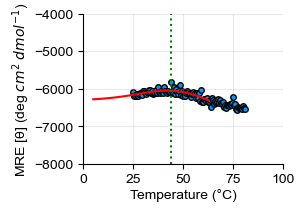

,mutant,lit state,enthalpy,enthalpy std,Tm,Tm std,maximum,maximum std,minimum,minimum std,r_squared,correction folded,correction unfolded
0,DL121,Dark,-33487.428090,145.300737,35.139626,0.030707,-4663.725189,36.754201,-8131.819464,4.756477,0.980076,2.000000,-23.287354
0,DL121,Lit,-52041.628350,74.715040,33.462773,0.007182,-4111.988507,3.476473,-7148.533983,2.285672,0.952672,2.000000,-29.161070
0,D87A,Dark,-42280.948796,104.670235,30.826942,0.013254,-5011.921422,11.231015,-8611.954438,4.952410,0.977162,2.000000,-33.634829
0,D87A,Lit,-48740.589420,66.570373,30.044556,0.012159,-4687.502246,1.873466,-7688.730398,3.559691,0.961256,2.000000,-32.172239
0,M16P,Dark,-36887.436526,137.286886,35.502073,0.030738,-5573.911974,32.596528,-8088.648857,3.751257,0.984282,2.000000,-2.327863
0,M16P,Lit,-52991.049412,50.787517,37.861757,0.004479,-4224.621169,2.745237,-7569.042514,1.397332,0.967518,2.000000,-24.116911
0,M16A,Dark,-20425.888193,246.410848,37.186601,0.129777,-3982.162121,150.855634,-8553.714928,6.714048,0.919983,-2.000000,-22.495340
0,M16A,Lit,-39462.733853,61.943068,34.567124,0.011608,-4295.992410,4.255454,-7543.031847,2.762785,0.934304,2.000000,-27.315464
0,DL116,Dark,-88373.619442,468.837626,39.437135,0.019156,-5086.193744,2.335627,-6835.194224,3.952036,0.695802,2.000000,-31.708266
0,DL116,Lit,-150000.000000,1242.856270,37.544456,0.014751,-5737.755333,1.133052,-6444.850859,3.058526,0.352088,-1.018222,-13.212543


In [31]:
#this is the cell that brings it all together and runs the functions on the different sets of data. 

to_plot = 'no'
melt_df = pd.DataFrame()
dark_df = pd.DataFrame()
lit_df = pd.DataFrame()

#cycle through the mutants in the 
for count in range(0, 26):   
    temp = pd.DataFrame()
    melt_mutant, light_state, melt_merge, CD_values \
    = melt_cycler(count, to_plot, melt_path, melt_list)
    #             row, to_plot, melt_path, melt_list
    #end = pd.Series(CD_values).idxmax()
    #CD_values = CD_values.dropna()
    #find the maximum CD point while HT values are still rising. 
    ht_max_position = pd.Series(melt_merge.HT.values).idxmax()
    #find the maximum before HT values cap out, this is where we will stop our fitting. (end)
    cd_max_position = pd.Series(CD_values[0:ht_max_position]).idxmax()
    #set end as 50% between the max cd value (before max ht value) and max ht value
    end = int(cd_max_position + np.round(1*((ht_max_position - cd_max_position)/2)))
    #end = ht_max_position #- 10
    #end = pd.Series(CD_values[0:ht_max_position]).idxmax() + 10
    
#Guessing initial values
    #YMAX
    top = CD_values[pd.Series(CD_values[0:end]).idxmax()]
    #YMIN
    bottom = CD_values[pd.Series(CD_values[0:end]).idxmin()]
    #Value of X at YMID, 
    #this one is more tricky, I need to search the array of cd values for the value closest to max-min
    ymid = (bottom + ((top - bottom)/2))
    difference_array = np.absolute(CD_values[0:pd.Series(CD_values[0:end]).idxmax()]-ymid)
    # find the index of minimum element from the array
    ymid_idx = difference_array.idxmin()
    #ymid_idx = (np.abs(array - value)).argmin()
    mid = melt_merge.TEMPERATURE.values[ymid_idx]
    print(mid)
    print(bottom)
    print(top)
    print(pd.Series(CD_values[0:end]).idxmax())
    print(melt_merge.TEMPERATURE.values[pd.Series(CD_values[0:end]).idxmax()])
    #what is the temperature when the cd value is at max? 
    top_tm = melt_merge.TEMPERATURE.values[pd.Series(CD_values[0:end]).idxmax()]
    
    #maximum and minimum are multiplied to give the curve some wiggle room. 
    fit_bounds = [[-150000,20,bottom*1.1,top*1.2,-2,-150], \
              [0,top_tm,bottom*0.90,top*0.8,2,10]]
    #the initial guess allows the curve fit to come to a reasonable answer more quickly, instead of falling into an impossible minima elsewhere
    initial_guess = [-30000, mid, bottom, top, 1, -45]
    
#apply the nature_method function to fit the sigmoid
    starting_enthalpy, starting_enthalpy_std, estimated_v50_2bs, estimated_v50_std_2bs, maximum_2bs,\
    maximum_std_2bs, minimum_2bs, minimum_std_2bs, correction_folded, correction_folded_std,\
    correction_unfolded, correction_unfolded_std, r_squared_2bs\
    = nature_method(melt_merge.TEMPERATURE.values, CD_values, end,to_plot,melt_mutant,light_state,initial_guess,fit_bounds)
    #save the values as a pandas dataframe inside the loop. 
    temp = pd.DataFrame([[melt_mutant, light_state, starting_enthalpy, starting_enthalpy_std,\
                          estimated_v50_2bs, estimated_v50_std_2bs, maximum_2bs,\
                          maximum_std_2bs, minimum_2bs, minimum_std_2bs, r_squared_2bs,\
                          correction_folded, correction_unfolded]],\
                            columns=['mutant', 'lit state','enthalpy', 'enthalpy std', 'Tm', 'Tm std', \
                                     'maximum', 'maximum std', 'minimum', 'minimum std', 'r_squared',\
                                     'correction folded', 'correction unfolded'])
    if light_state == 'Dark':
        dark = pd.DataFrame([[melt_mutant, estimated_v50_2bs, estimated_v50_std_2bs, r_squared_2bs]],\
                             columns=['mutant', 'Tm_dark', 'Tm_dark_std', 'r_squared_dark'])
        dark_df = pd.concat([dark_df, dark])
    else:
        lit = pd.DataFrame([[melt_mutant, estimated_v50_2bs, estimated_v50_std_2bs, r_squared_2bs]],\
                             columns=['mutant', 'Tm_lit', 'Tm_lit_std', 'r_squared_lit'])
        lit_df = pd.concat([lit_df, lit])
    #add these temporary values to the melt_df pandas dataframe and then continue the loop to the next mutant
    melt_df = pd.concat([melt_df, temp])

#combine dark and lit into one entery per mutant, so it can be combined with the energetics data. 
Tm_df = dark_df.merge(lit_df, how='left', on = ['mutant'])
#save out the dataframe as a table. 
#melt_df.to_csv('./output/melt_df.csv')
melt_df

Now we want to take a look at how the melt data from the CD measurements compare with the energetics from eyring kinetic experiments. 
We start by loading in the CSV file from Thermal_kinetics_and_stability_analysis

In [32]:
#load the data from the eyring thermodynamics experiments and combine with the melt data.
#this loads the energetics file calculated from kinetics measurements done at 5 to 35C with statistics 
#calculated from 5000 bootstrapping iterations. 
#Temperature calculations are done at 30C, which is the temperature of the invivo growth assays from McCormick 2021.   
energetics_path = './output/energetics_df_5-35C_5000boot.csv' #30C
#alternate csv file with the same information but where temperature is calculated at 17.5C
#energetics_path = './output/energetics_df_5-35C_5000boot_17.5.csv' #17.5C
energetics_df = pd.read_csv(energetics_path,header=(0)) 
combined_df = energetics_df.merge(Tm_df, how='left', on = ['mutant'])
combined_df

,Unnamed: 0,mutant,csv,dark_enthalpy_mean,dark_enthalpy_std,dark_entropy_mean,dark_entropy_std,lit_enthalpy_mean,lit_enthalpy_std,lit_entropy_mean,...,ddelta_enthalpy_mean,ddelta_enthalpy_std,fol_distance,corex score,Tm_dark,Tm_dark_std,r_squared_dark,Tm_lit,Tm_lit_std,r_squared_lit
0,0,DL121,./input_data/eyring/dl121_eyring.csv,12.616080,0.161810,-17.353539,0.550739,10.951452,0.454782,-22.421308,...,0.000000,0.000000,0.00,NaN,35.139626,0.030707,0.980076,33.462773,0.007182,0.952672
1,0,A9N,./input_data/eyring/a9n_eyring.csv,10.484176,0.499373,-23.851298,1.714027,7.910597,0.866592,-31.803239,...,-908.950703,1100.958767,9.24,NaN,35.835569,0.021203,0.986195,38.488568,0.003560,0.954642
2,0,M16A,./input_data/eyring/m16a_eyring.csv,12.971744,0.696919,-17.809741,2.334727,11.303475,0.474708,-22.701684,...,-3.640499,968.188621,10.24,NaN,37.186601,0.129777,0.919983,34.567124,0.011608,0.934304
3,0,M16P,./input_data/eyring/m16p_eyring.csv,13.156230,0.646546,-20.185232,2.164338,11.742906,0.840369,-24.812622,...,251.304598,1171.018071,10.24,NaN,35.502073,0.030738,0.984282,37.861757,0.004479,0.967518
4,0,G86K,./input_data/eyring/g86k_eyring.csv,8.321717,0.255156,-32.034706,0.866960,7.641702,0.275955,-33.842019,...,984.613884,614.265125,19.52,NaN,29.746222,0.017855,0.973238,27.785975,0.009265,0.945978
5,0,D87A,./input_data/eyring/d87a_eyring.csv,11.662790,0.394364,-20.065079,1.339850,9.520078,0.432347,-26.927964,...,-478.082837,757.003122,20.80,NaN,30.826942,0.013254,0.977162,30.044556,0.012159,0.961256
6,0,R98M,./input_data/eyring/r98m_eyring.csv,8.962137,0.265481,-28.958195,0.899863,7.842981,0.253370,-32.065071,...,545.473065,599.729754,11.69,NaN,31.964075,0.008370,0.988122,32.864236,0.006942,0.989156
7,0,D116M,./input_data/eyring/d116m_eyring.csv,6.458452,0.328429,-36.433128,1.120010,5.312499,0.301670,-40.048300,...,518.675458,650.319537,11.87,NaN,32.252979,0.028696,0.968869,33.223006,0.037675,0.846942
8,0,H124Q,./input_data/eyring/h124q_eyring.csv,8.909612,0.311516,-29.861074,1.058777,7.859143,0.460853,-32.856213,...,614.159459,734.249134,11.04,NaN,31.771423,0.011135,0.972077,34.044392,0.013398,0.943144
9,0,D127W,./input_data/eyring/d127w_eyring.csv,8.359063,0.950598,-32.831763,3.247319,7.303681,0.633547,-35.382564,...,609.247304,1244.517178,15.88,NaN,37.962225,0.148325,0.990789,34.075435,0.007081,0.969796


In [33]:
#now I want to reindex the pandas dataframe so that the mutants are sorted by this allosteric effect. 
combined_df.sort_values(by=['kcat_ratio_mean'], inplace=True)
combined_df = combined_df.reset_index(drop=True)

In [34]:
#lets calculate the allosteric effect of kcat_lit/kcat_dark relative to DL121 so that we can make a color bar of it. 
color_scale = []
y = combined_df[['kcat_ratio_mean']].to_numpy().T
for i, txt in enumerate(combined_df['mutant']):
    color = np.subtract(y[0][i],y[0][3]) #30C
#    color = np.subtract(y[0][i],y[0][5]) #17.5    
    color_scale.append(color)
offset = colors.TwoSlopeNorm(0)
wowzers = plt.cm.RdBu(offset(color_scale))

Lets plot the Tm of the mutants and color the lit bars based on their allosteric effect of kcat_lit/kcat_dark relative to DL121

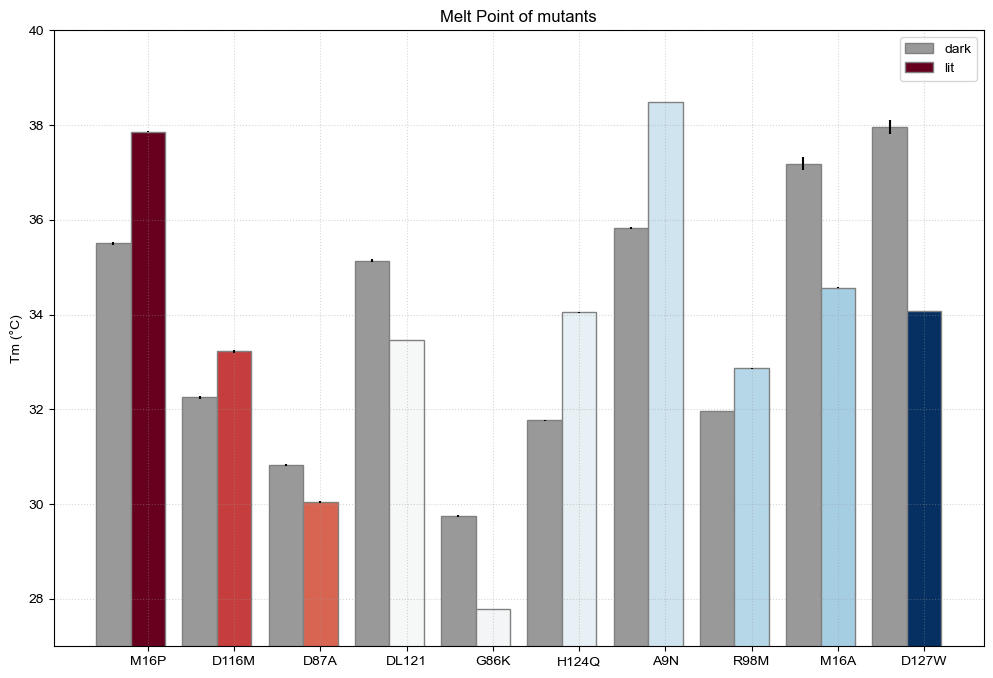

In [42]:
#Tm vs categories

fig = plt.subplots(figsize =(12, 8)) 
barWidth = 0.4
plt.grid("both", alpha=0.4,ls=":")
br1 = np.arange(len(combined_df['Tm_lit'])) 
br2 = [x + barWidth for x in br1] 

#error bars are 1 std 
yerr_lit= combined_df[['Tm_lit_std']].to_numpy().T
yerr_dark = combined_df[['Tm_dark_std']].to_numpy().T
#plot the bars
plt.bar(br1, combined_df['Tm_dark'], yerr=yerr_dark, edgecolor ='grey', label ='dark',width = barWidth,color ="#999999")
plt.bar(br2, combined_df['Tm_lit'], yerr=yerr_lit, edgecolor ='grey', label ='lit',width = barWidth,color =wowzers)
#plt.bar(br2, combined_df['Tm_dark'], yerr=yerr_dark, edgecolor ='grey', label ='dark',width = barWidth,color ="#999999")       

plt.xticks([r + barWidth for r in range(len(combined_df['Tm_lit']))], 
       combined_df['mutant'])
plt.ylim(27, 40)
plt.legend()
#plt.xlabel('ΔGǂLit - ΔGǂDark (kcal/mol at 17.5°C)')
plt.ylabel('Tm (°C)')
title = ('Melt Point of mutants')
plt.title(title)
#to_plot = 'no'
if to_plot == 'yes':
    figure_name = ('mutant_Tm.pdf')
    plt.savefig('./output/%s' % figure_name, bbox_inches='tight')
plt.show()
#arrange by allostery effect. 
#beneficial to allostery, deleterious, or neutral

Lets plot the relationship between allosteric melt (TM lit - TM dark) and lit-dark gibs free energy.
Line of best fit is calculated and plotted, with mutants not used in the fit circled in red. 
The mutants are colored based on their allosteric effect of kcat_lit/kcat_dark relative to DL121

Intercept, x-Slope : Intercept    1.575457
x            0.021782
dtype: float64


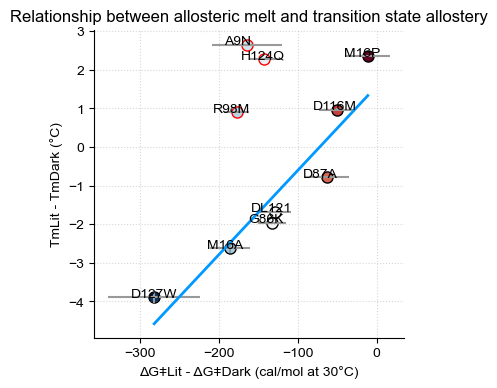

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     35.67
Date:                Wed, 28 Aug 2024   Prob (F-statistic):            0.00188
Time:                        14:50:45   Log-Likelihood:                -7.3856
No. Observations:                   7   AIC:                             18.77
Df Residuals:                       5   BIC:                             18.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5755      0.543      2.900      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [39]:
data_plot_df = pd.DataFrame()
plt.subplots(figsize =(4, 4))
plt.grid("both", alpha=0.4,ls=":")
rcParams['lines.markersize'] = 8
#plot the names of the mutants
for i, txt in enumerate(combined_df['mutant']):
    
    #checks that there are no NaN in the temperature
    if combined_df['Tm_lit'][i] != combined_df['Tm_lit'][i]:
        continue
    
    d_tm = np.subtract(combined_df['Tm_lit'][i]\
                        ,combined_df['Tm_dark'][i])
    y = d_tm
    y_err = np.sqrt(np.square(combined_df['Tm_lit_std'][i]) + np.square(combined_df['Tm_dark_std'][i]))
    x = combined_df['ddelta_G_mean'][i]
    x_err = combined_df['ddelta_G_std'][i]
    #excludes A9N from linnear regression
    if txt == 'A9N':
        plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
        plt.scatter(x, y, color=wowzers[i] , edgecolors='red')
        plt.annotate(txt, (combined_df['ddelta_G_mean'][i] - 30, d_tm))
    #excludes H124Q and R98M from linnear regression
    else:
        if txt == 'H124Q' or txt == 'R98M':
            plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
            plt.scatter(x, y, color=wowzers[i] , edgecolors='red')
            plt.annotate(txt, (combined_df['ddelta_G_mean'][i] - 30, d_tm))
        else:
            plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
            plt.scatter(combined_df['ddelta_G_mean'][i], d_tm, 
                        color=wowzers[i], edgecolors='black'#, norm=TwoSlopeNorm(0) 
                        )
            plt.annotate(txt, (combined_df['ddelta_G_mean'][i] - 30, d_tm))
            data_plot_temp = pd.DataFrame([[combined_df['ddelta_G_mean'][i], d_tm]],\
                             columns=['x', 'y'])
            data_plot_df = pd.concat([data_plot_df, data_plot_temp])

data_plot_df = data_plot_df.dropna()
ols_model = sm.ols(formula = 'y ~ x', data=data_plot_df)
results = ols_model.fit()
#plt.colorbar()
# coefficients
print('Intercept, x-Slope : {}'.format(results.params))
y_pred = ols_model.fit().predict(data_plot_df['x'])

# plot results
plt.gca().spines[['right', 'top']].set_visible(False)   
plt.plot(data_plot_df['x'], y_pred, linewidth=2, c="#0099FF" )
plt.grid(True)
plt.xlabel('ΔGǂLit - ΔGǂDark (cal/mol at 30°C)')
plt.ylabel('TmLit - TmDark (°C)')
title = ('Relationship between allosteric melt and transition state allostery')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('melt_vs_energetics 5-35C @ 30C.pdf')
    plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
plt.show()  
print(results.summary())

Lets plot the relationship between allosteric melt (TM lit - TM dark) and lit-dark transition state enthalpy.
Line of best fit is calculated and plotted, with mutants not used in the fit circled in red. 
The mutants are colored based on their allosteric effect of kcat_lit/kcat_dark relative to DL121

Intercept, x-Slope : Intercept   -1.637169
x           -0.001006
dtype: float64


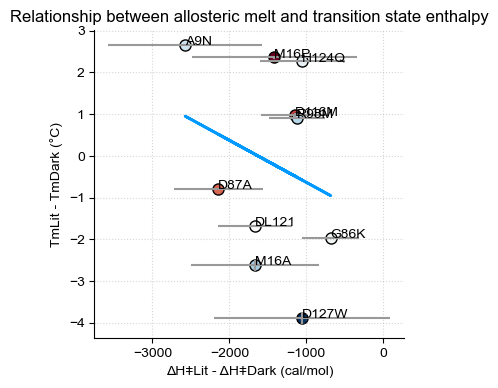

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                    0.5250
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.489
Time:                        14:51:31   Log-Likelihood:                -21.761
No. Observations:                  10   AIC:                             47.52
Df Residuals:                       8   BIC:                             48.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6372      2.152     -0.761      0.4

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [40]:
#goal of this cell is to plot the relationship between allosteric melt and transition state enthalpy
data_plot_df = pd.DataFrame()
plt.subplots(figsize =(4, 4)) 
plt.grid("both", alpha=0.4,ls=":")
plt.gca().spines[['right', 'top']].set_visible(False)   
#plot the names of the mutants
for i, txt in enumerate(combined_df['mutant']):
    
    #checks that there are no NaN in the temperature
    if combined_df['Tm_lit'][i] != combined_df['Tm_lit'][i]:
        continue
    
    d_tm = np.subtract(combined_df['Tm_lit'][i]\
                        ,combined_df['Tm_dark'][i])
    y = d_tm
    y_err = np.sqrt(np.square(combined_df['Tm_lit_std'][i]) + np.square(combined_df['Tm_dark_std'][i]))

    x = combined_df['delta_enthalpy_mean'][i]
    x_err = combined_df['delta_enthalpy_std'][i]

    #excludes A9N from linnear regression
    if txt == 'A9n': #set as A9n so that A9N is not excluded. Change back to A9N if you want it excluded
        plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
        plt.scatter(x, y, color=wowzers[i], edgecolors='red')
        plt.annotate(txt, (x -1, y))
    else:
        if txt == 'M16Ap': #set as M16p so that M16P is not excluded. Change back to M16P if you want it excluded
            plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
            plt.scatter(x, y, color=wowzers[i], edgecolors='red')
            plt.annotate(txt, (x -1, y))
        else:
            plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
            plt.scatter(x, y, color=wowzers[i], edgecolors='black')
            plt.annotate(txt, (x -1, y))
            data_plot_temp = pd.DataFrame([[x, y]],\
                             columns=['x', 'y'])
            data_plot_df = pd.concat([data_plot_df, data_plot_temp])
data_plot_df = data_plot_df.dropna()
ols_model = sm.ols(formula = 'y ~ x', data=data_plot_df)
results = ols_model.fit()

# coefficients
print('Intercept, x-Slope : {}'.format(results.params))
y_pred = ols_model.fit().predict(data_plot_df['x'])

# plot results

plt.plot(data_plot_df['x'], y_pred, linewidth=2, c="#0099FF" )
plt.grid(True)
plt.xlabel('ΔHǂLit - ΔHǂDark (cal/mol)')
plt.ylabel('TmLit - TmDark (°C)')
title = ('Relationship between allosteric melt and transition state enthalpy')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('melt_vs_enthalpy 5-35C.pdf')
    plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
plt.show()  
print(results.summary())

Lets plot the relationship between allosteric melt (TM lit - TM dark) and lit-dark transition state entropy.
Line of best fit is calculated and plotted, with mutants not used in the fit circled in red. 
The mutants are colored based on their allosteric effect of kcat_lit/kcat_dark relative to DL121

Intercept, x-Slope : Intercept   -1.808560
x           -0.001239
dtype: float64


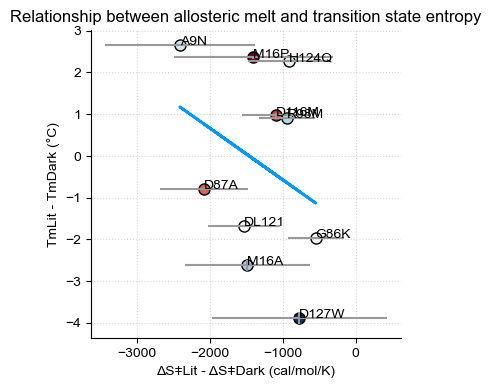

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.8716
Date:                Wed, 28 Aug 2024   Prob (F-statistic):              0.378
Time:                        14:51:52   Log-Likelihood:                -21.562
No. Observations:                  10   AIC:                             47.12
Df Residuals:                       8   BIC:                             47.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8086      1.897     -0.953      0.3

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [41]:
#goal of this cell is to plot the relationship between allosteric melt and transition state entropy
data_plot_df = pd.DataFrame()
plt.subplots(figsize =(4, 4)) 
plt.grid("both", alpha=0.4,ls=":")
plt.gca().spines[['right', 'top']].set_visible(False)   
#plot the names of the mutants
for i, txt in enumerate(combined_df['mutant']):
    
    #checks that there are no NaN in the temperature
    if combined_df['Tm_lit'][i] != combined_df['Tm_lit'][i]:
        continue
    
    d_tm = np.subtract(combined_df['Tm_lit'][i]\
                        ,combined_df['Tm_dark'][i])
    y = d_tm
    y_err = np.sqrt(np.square(combined_df['Tm_lit_std'][i]) + np.square(combined_df['Tm_dark_std'][i]))

    x = combined_df['delta_entropy_mean'][i]
    x_err = combined_df['delta_entropy_std'][i]


    #excludes A9N from linnear regression
    if txt == 'A9n':
        plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
        plt.scatter(x, y, color=wowzers[i], edgecolors='red')
        plt.annotate(txt, (x -1, y))
    else:
        if txt == 'M16Ap':
            plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
            plt.scatter(x, y, color=wowzers[i], edgecolors='red')
            plt.annotate(txt, (x -1, y))
        else:
            plt.errorbar(x, y, yerr=y_err, xerr=x_err, c="#999999" )
            plt.scatter(x, y, color=wowzers[i], edgecolors='black')
            plt.annotate(txt, (x -1, y))
            data_plot_temp = pd.DataFrame([[x, y]],\
                             columns=['x', 'y'])
            data_plot_df = pd.concat([data_plot_df, data_plot_temp])
data_plot_df = data_plot_df.dropna()
ols_model = sm.ols(formula = 'y ~ x', data=data_plot_df)
results = ols_model.fit()

# coefficients
print('Intercept, x-Slope : {}'.format(results.params))
y_pred = ols_model.fit().predict(data_plot_df['x'])

# plot results
plt.plot(data_plot_df['x'], y_pred, linewidth=2, c="#0099FF" )
plt.grid(True)
plt.xlabel('ΔSǂLit - ΔSǂDark (cal/mol/K)')
plt.ylabel('TmLit - TmDark (°C)')
title = ('Relationship between allosteric melt and transition state entropy')
plt.title(title)
if to_plot == 'yes':
    figure_name = ('melt_vs_entropy 5-35C.pdf')
    plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
plt.show()  
print(results.summary())

In addition to the melt, the spectral scans of select mutants was taken. 

In [46]:
#load the list of all the file names
mutant_spectrum_path = './input_data/mutant_spectral_scans/'
mutant_spectral_list = pd.read_csv(mutant_spectrum_path + 'melt_list.csv',header=(0))
mutant_spectral_list
#need to add a conditions section, IE mutant name, and molarity to calculate CD properly. 

,Mutant,Light,Read 1,Read 2,Read 3,Concentration,skiprows,nrows
0,DL121,Dark,DL121-1.csv,NaN,NaN,0.9090,20.0,701.0
1,DL121,Lit,DL121-2.csv,DL121-3.csv,DL121-4.csv,0.9090,20.0,701.0
2,A9N,Dark,Dl121-A9N dark-1.csv,Dl121-A9N dark-2.csv,Dl121-A9N dark-3.csv,0.9500,20.0,701.0
3,A9N,Lit,Dl121-A9N lit-1.csv,Dl121-A9N lit-2.csv,Dl121-A9N lit-3.csv,0.9500,20.0,701.0
4,D87A,Dark,Dl121-D87A-1-dark.csv,NaN,NaN,0.9290,20.0,701.0
5,D87A,Lit,Dl121-D87A-2 lit.csv,NaN,NaN,0.9290,20.0,701.0
6,R98M,Dark,DL121_R98M-1.csv,DL121_R98M-2.csv,DL121_R98M-3.csv,0.8850,20.0,601.0
7,R98M,Lit,DL121_R98M_lit-1.csv,DL121_R98M_lit-2.csv,DL121_R98M_lit-3.csv,0.8850,20.0,601.0
8,D116M,Dark,Dl121-D116M dark-1.csv,Dl121-D116M dark-2.csv,Dl121-D116M dark-3.csv,0.9400,20.0,701.0
9,D116M,Lit,Dl121-D116M lit 2-1.csv,Dl121-D116M lit 2-2.csv,Dl121-D116M lit 2-3.csv,0.9400,20.0,701.0


Again we need a function to detect the light blips and remove them. Because not every mutant has three scans,
the above function has here been adjusted to permit for varying amounts of scans, and also scans that may begin with a light blip, which would cause an error in the previous functions. Otherwise it is the same as the change_detector function for the DL121 temperature scan series.  

In [47]:
#lets make it a function
def change_detector_mutant(x, y, ycd): 
    #x = spectra_1.wavelength.values
    #y = spectra_1.HT.values
    #ycd = spectra_1.CD

    jump_idxs = []
    ## compute the second derivative to identify jumps. # dy = diff(y, n=1)/dx
    deriv = np.diff(y, n=2)
    #deriv = np.gradient(y)

    ## find index locations of jumps
    jump_threshold = 0.5
    jump_idxs_temp = np.where(np.abs(deriv)>jump_threshold)[0]
    #jump_idxs_temp = np.where(deriv<jump_threshold)[0]
    j=0
    flipper = "start"
    for i in jump_idxs_temp:
        j=j+1
        #correct against a strong jump at the start. 
        if i == 0:
            continue
        if np.any(jump_idxs) == False:
            jump_idxs.append(i)
            flipper = "end"
        else:
            try: 
                i < np.add(jump_idxs_temp[j],10)
            except IndexError:
                jump_idxs.append(i)
                flipper = "end"
                continue
            if flipper == "start":
                #-1 to adjust for second derivative
                if i > np.add(jump_idxs[-1],30):
                    flipper = "end"
                    jump_idxs.append(i)
            else:
                #this is to find the outer edge, where there shouldnt be another blip for a while
                if i < np.add(jump_idxs_temp[j],-30) and i > np.add(jump_idxs[-1],10):
                    flipper = "start"
                    jump_idxs.append(i)
    flipper = "off"
    for i in ycd.index:
        if flipper == "off":
            if i in jump_idxs:
                ycd.values[i] = "NaN"
                flipper = "on"
        else:
            if flipper == "on":
                ycd.values[i] = "NaN"
                if i in jump_idxs:
                    flipper = "off"
                    
    return jump_idxs, ycd  

This function reads the pandas dataframe mutant_spectral_list, using row as an input to determine which mutant and paramaters to read out. 
It then uses the change_detector_mutant function to identify light blips, uses cd_convert to convert the CD values to MRE, and then plots the spectra in the light and dark for each mutant. 

In [48]:
 def mutant_spectrizer(row): 
    lit_list = []
    lit_temperature_list = []
    dark_list = []
    dark_temperature_list = []
    
    ax = plt
    a1 = ax.figure().add_axes([0,0,1,1])
    a1.set_ylabel("MRE [θ] (deg $cm^{2}$ $dmol^{-1}$)", labelpad=2)
    a1.set_xlabel("Wavelength (nm)", labelpad=8)
    ax.grid("both", alpha=0.2)
    
    for row in range(row,row+2):
    #set where to look in the files for the data. Reading JASCO output csv files. 
        #how far down to look, ie if first cell with data is the 21st, the number should be 20. 
        skiprows = mutant_spectral_list['skiprows'][row]
        #how far the data extends, ie if last cell with data is the 621st, the number should be cell number 601 (621-skiprows). 
        nrows = mutant_spectral_list['nrows'][row]
    #pull data out of CD output files    
        spectra_1_name = mutant_spectral_list['Read 1'][row]
        spectra_1 = pd.read_csv(mutant_spectrum_path + spectra_1_name,header=None,skiprows=20,nrows=nrows)
    #    spectra_1 = pd.read_csv(mutant_spectrum_path + spectra_1_name,header=None,skiprows=skiprows,nrows=nrows)
        spectra_1.columns =['wavelength', 'CD', 'HT']
    #output file 2
        spectra_2_name = mutant_spectral_list['Read 2'][row]
        #if there is no spectra_2 in file, then skip and continue
        #this works because nan equals no values, including itself. 
        if spectra_2_name != spectra_2_name:
            spectra_2_name = spectra_1_name 
        spectra_2 = pd.read_csv(mutant_spectrum_path + spectra_2_name,header=None,skiprows=20,nrows=nrows)
        spectra_2.columns =['wavelength', 'CD', 'HT']
    #output file 3
        spectra_3_name = mutant_spectral_list['Read 3'][row]
            #if there is no spectra_3 in file, then skip and continue
        #this works because nan equals no values, including itself. 
        if spectra_3_name != spectra_3_name:
            spectra_3_name = spectra_1_name 
        spectra_3 = pd.read_csv(mutant_spectrum_path + spectra_3_name,header=None,skiprows=20,nrows=nrows)
        spectra_3.columns =['wavelength', 'CD', 'HT']
    #pull lit/dark (light), concentration (concentration), and mutant name (spectral_mutant)
        spectral_mutant = mutant_spectral_list['Mutant'][row]
        light = mutant_spectral_list['Light'][row]
        concentration = mutant_spectral_list['Concentration'][row] 
        
        #if there is no concentration in file, then change it to equal that of DL121 (workaround)
        #this works because nan equals no values, including itself. 
        if concentration != concentration:
            concentration = mutant_spectral_list['Concentration'][0] 
            
        #data filter for light blips    
        spectra_1_jumps, spectra_1.CD = change_detector_mutant(spectra_1.wavelength.values, spectra_1.HT.values, spectra_1.CD)
        spectra_2_jumps, spectra_2.CD = change_detector_mutant(spectra_2.wavelength.values, spectra_2.HT.values, spectra_2.CD)
        spectra_3_jumps, spectra_3.CD = change_detector_mutant(spectra_3.wavelength.values, spectra_3.HT.values, spectra_3.CD)
        #average the 3
        spectra_merge = pd.concat([spectra_1, spectra_2, spectra_3]).groupby(level=0).mean()
        #plot
        
        x = spectra_merge.wavelength.values
        y = spectra_merge.HT.values
        ycd = cd_convert(spectra_merge.CD, 0.7, 0.1, 113.83)
        title = (mutant_spectral_list['Mutant'][row])
        if light == 'Lit':
            ax.scatter(x[0:550], ycd.values[0:550], c="#0099FF", s=1)
            #continue
        else:
            ax.scatter(x[0:550], ycd.values[0:550], c="#999999", s=1)
            plt.ylim(np.nanmin(ycd.values[0:550]-500),1000)
            continue
        #ax.legend()
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.title(title)
    #ax.legend().set_visible(False)
    #to_plot = 'yes'
    plt.xlim(205, 260)
    #plt.ylim(np.nanmin(ycd.values[0:550])-1000,np.nanmax(ycd.values[0:550]))
    #to_plot = 'no'
    if to_plot == 'yes':
        figure_name = ('%s_spectra.pdf' % title)
        plt.savefig('./output/CD_curves/%s' % figure_name, bbox_inches='tight')
    plt.show()    

Here is where mutant_spectrizer is run. it is given in increments of two because they are paired in light/dark. 
Note that some mutants have gaps in them. This is where there a light blip is detected and removed from every read of that wavelength, 
either due to overlapping light blips in different scans, or that there was only one scan (or averaged on the machine before the light blip can be identified and removed). 

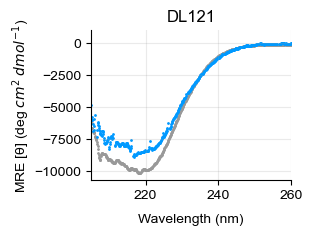

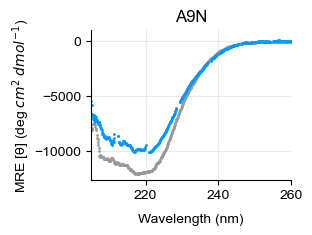

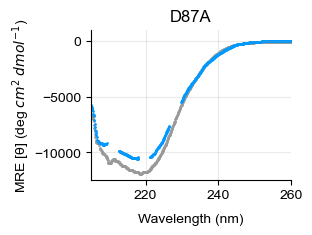

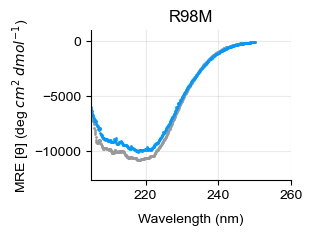

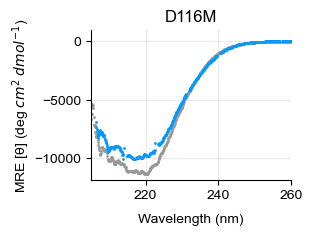

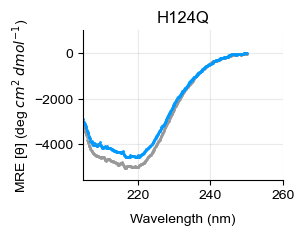

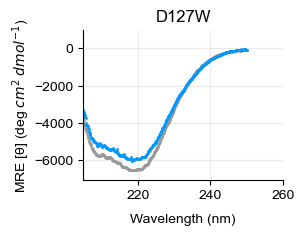

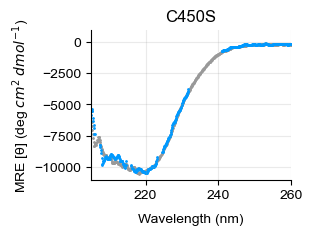

In [49]:
#run the function. 
for row in range(0,16,2):
    mutant_spectrizer(row)